In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
K=8
death_ratio = np.array([0.00000000e+00, 3.36964689e-06, 2.19595034e-05, 4.49107573e-05,
               1.88422215e-04, 4.99762978e-04, 1.89895681e-03, 7.40632275e-03])

Text(0, 0.5, 'Death ratio')

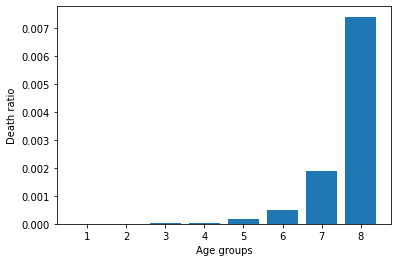

In [5]:
plt.bar(range(1,9), death_ratio)
plt.xlabel("Age groups")
plt.ylabel("Death ratio")

In [3]:
all_death = pd.read_csv("../data/orszagos_halott.csv", sep=',')[:755]
death_orig = np.array(all_death[181:181+180]["Hétnapos mozgóátlag"])

In [4]:
sett_types = pd.read_csv("../../../data/hun/HU_places_admin_pop_ZIP_latlon.csv",
           sep=',',
           header=0)

KSH = pd.read_csv("../../../data/hun/KSHCommuting_c1ID_c1name_c2ID_c2name_comm_school_work_DIR.csv",
           sep=',',
           header=0)

In [5]:
pops = sett_types.set_index("place").to_dict()["population"]
pops_code = sett_types.set_index("KSH code").to_dict()["population"]

In [6]:
sett_types

place  KSH code settlement type            admin county  \
0            Aba     17376      nagyközség                   Fejér   
1     Abádszalók     12441           város    Jász-Nagykun-Szolnok   
2       Abaliget     12548          község                 Baranya   
3         Abasár     24554          község                   Heves   
4     Abaújalpár     15662          község    Borsod-Abaúj-Zemplén   
...          ...       ...             ...                     ...   
3172     Zsennye     12292          község                     Vas   
3173       Zsira      4622          község       Győr-Moson-Sopron   
3174      Zsombó     17765          község                Csongrád   
3175      Zsujta     11022          község    Borsod-Abaúj-Zemplén   
3176       Zsurk     13037          község  Szabolcs-Szatmár-Bereg   

     admin municip  population   zip  latitude  longitude  
0              Aba        4619  8127   47.0291    18.5217  
1       Tiszafüred        3922  5241   47.4667    20.6000  
2             Pécs         586  7678   46.1426    18.1168  
3         Gyöngyös        2498  3261   47.7970    20.0032  
4             Encs          76  3882   48.3067    21.2332  
...            ...         ...   ...       ...        ...  
3172   Szombathely         100  9766   47.1130    16.8152  
3173        Sopron         782  9476   47.4576    16.6773  
3174        Szeged        3552  6792   46.3257    19.9746  
3175          Gönc         164  3897   48.5000    21.2833  
3176        Záhony         704  4627   48.4118    22.2195  

[3177 rows x 9 columns]

In [7]:
KSH

origID    origName  destID           destName  CommutersAll  \
0         1508   Ipolyszög    1508          Ipolyszög            40   
1         1508   Ipolyszög    3115        Dunaújváros             2   
2         1508   Ipolyszög    3179  Budapest 02. ker.             2   
3         1508   Ipolyszög    3249            Õrhalom             2   
4         1508   Ipolyszög    4507         Szendehely             4   
...        ...         ...     ...                ...           ...   
114040   34412  Mosonudvar   28149       Mosonszolnok            19   
114041   34412  Mosonudvar   29221       Jánossomorja             5   
114042   34412  Mosonudvar   31839           Újrónafõ             2   
114043   34412  Mosonudvar   34412         Mosonudvar            52   
114044   34412  Mosonudvar   40401           Ausztria             6   

        CommutersSchool  CommutersWork  
0                     0             40  
1                     0              2  
2                     0              2  
3                     0              2  
4                     0              4  
...                 ...            ...  
114040                0             19  
114041                0              5  
114042                0              2  
114043                0             52  
114044                0              6  

[114045 rows x 7 columns]

In [65]:
d = KSH.groupby("origName").sum().to_dict()["CommutersAll"]

In [66]:
home_proc = {}
S = 0
for i,row in KSH.iterrows():
    if(row["origID"] == row["destID"]):
        #print(row["origName"], row["CommutersAll"]/d[row["origName"]])
        S+=1
        home_proc[row["origID"]] = (pops_code[row["origID"]], row["CommutersAll"]/d[row["origName"]], row["origName"])
print(S)

3071


In [67]:
arr = np.array(list(home_proc.values()))

In [68]:
np.array(arr[:,0], dtype=int)

array([ 639, 2152, 3311, ..., 1128, 3632,  498])

Text(0, 0.5, 'Commuting in city')

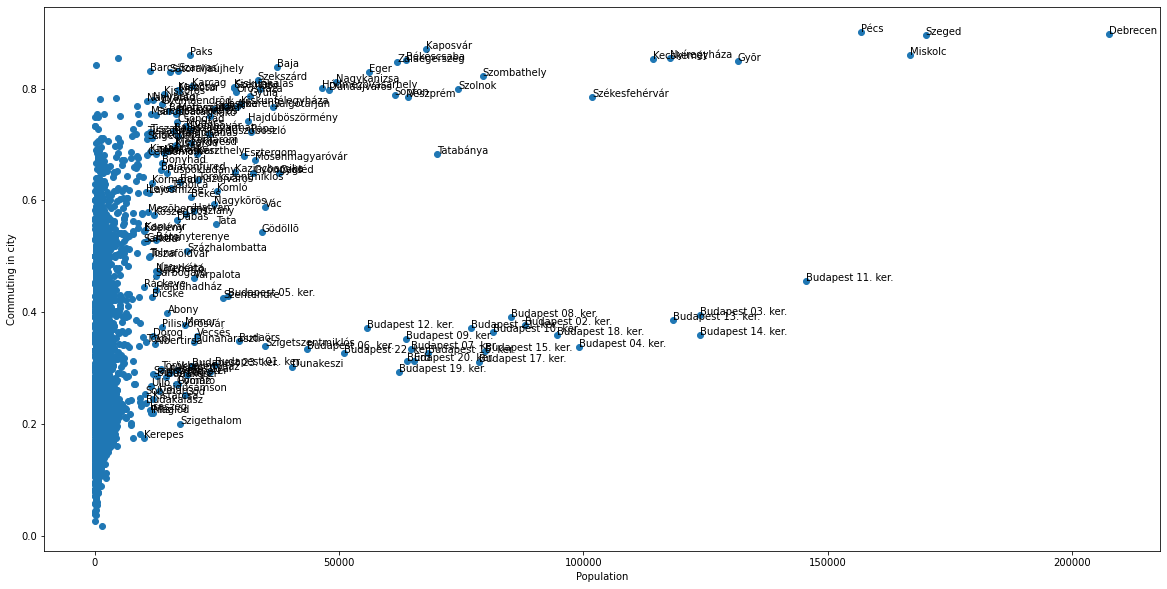

In [69]:
plt.figure(figsize=(20,10))
X = np.array(arr[:,0], dtype=int)
Y = np.array(arr[:,1], dtype=float)
plt.scatter(X, Y)

for i, label in enumerate(arr[:,2]):
    if(X[i]>10000):
        plt.annotate(label, (X[i], Y[i]))

plt.xlabel("Population")
plt.ylabel("Commuting in city")

In [8]:
def get_inf_curve(filename, death = None, K= 8):
    df = pd.read_csv(filename, sep=',')
    inf_cols = [c for c in df.columns if c[0:2]=='I_']
    inf_cols2 = [c for c in df.columns if c[0:2]=='I2']
    Is = df.filter(inf_cols, axis=1)
    Is2 = df.filter(inf_cols2, axis=1)
    
    I = np.zeros((len(Is), K, len(Is.columns)//K))
    for c in Is.columns:
        _,city,age = c.split("_")
        I[:,int(age), int(city)] = Is.loc[:, c]
    I2 = np.zeros((len(Is2), K, len(Is2.columns)//K))
    for c in Is2.columns:
        _,city,age = c.split("_")
        I2[:,int(age), int(city)] = Is2.loc[:, c]
    
    I = np.sum(I, axis=2)
    I2 = np.sum(I2, axis=2)
    if type(death) != None:
        return np.sum(I*death, axis=1)+np.sum(I2*death, axis=1), Is.sum(axis=1), Is2.sum(axis=1)
    else:
        return Is.sum(axis=1), Is2.sum(axis=1)

def get_inf_curve2(filename, death_ratio, all_death, K= 8):
    df = pd.read_csv(filename, sep=',')
    inf_cols = [c for c in df.columns if c[0:2]=='I_']
    inf_cols2 = [c for c in df.columns if c[0:2]=='I2']
    Is = df.filter(inf_cols, axis=1)
    Is2 = df.filter(inf_cols2, axis=1)
    
    I = np.zeros((len(Is), K, len(Is.columns)//K))
    for c in Is.columns:
        _,city,age = c.split("_")
        I[:,int(age), int(city)] = Is.loc[:, c]
    I2 = np.zeros((len(Is2), K, len(Is2.columns)//K))
    for c in Is2.columns:
        _,city,age = c.split("_")
        I2[:,int(age), int(city)] = Is2.loc[:, c]
    
    I = np.sum(I, axis=2)
    I2 = np.sum(I2, axis=2)
    if type(death) != None:
        return np.sum(I*death_ratio*(all_death/np.sum(I)), axis=1), Is.sum(axis=1), Is2.sum(axis=1)
    else:
        return Is.sum(axis=1), Is2.sum(axis=1)

def fit(x,y):
    min_ind = 0
    MIN = 1e12
    for shift in range(25):
        orig_shifted = x[shift:len(y)+25-(25-shift)]
        l2 = np.sqrt(np.sum((orig_shifted-y)**2))
        if l2 < MIN:
            MIN = l2
            min_ind = shift
    return min_ind, MIN



R0=1.84 ==> Optimal shift: 22 (l2 = 370.1737642149865)
R0=1.89 ==> Optimal shift: 24 (l2 = 401.6959461616061)
R0=1.95 ==> Optimal shift: 24 (l2 = 445.7281255186971)
R0=2.00 ==> Optimal shift: 24 (l2 = 501.77630040062024)


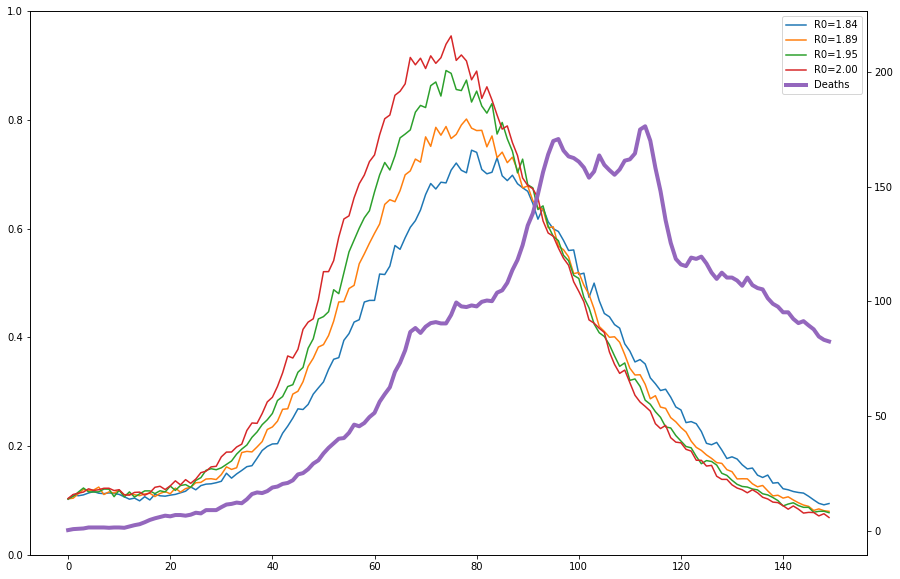

In [6]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
ax2 = ax.twinx()
x = np.array(list(range(150)))

for i,R0 in zip(range(20)[16:], np.linspace(1.0, 2.0, 20)[16:]):
    death, Is,_ = get_inf_curve(f"../../output/R0_K2/{i}.txt", death = death_ratio*10)
    ax2.plot(x, death, label=f"R0={R0:.2f}")
    
    shift, l2 = fit(death_orig, death)
    print(f"R0={R0:.2f} ==> Optimal shift: {shift} (l2 = {l2})")

lns1 = ax2.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)
plt.legend()

R0=1.84 ==> Optimal shift: 22 (l2 = 370.1737642149865)


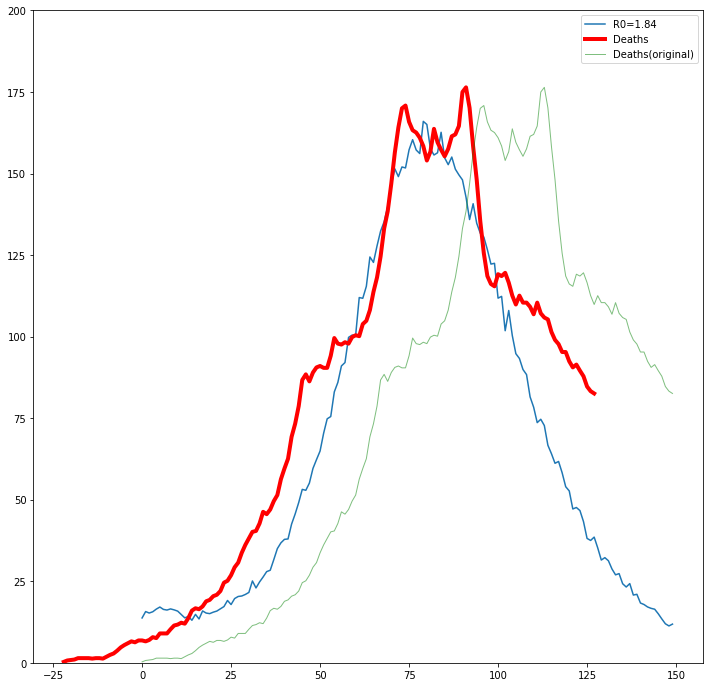

In [7]:
plt.figure(figsize=(12,12))
i,R0 = 16,1.84
death, Is, _ = get_inf_curve(f"../../output/R0_K2/{i}.txt", death = (death_ratio**1)*10)
shift, l2 = fit(death_orig, death)
plt.plot(x[:len(death)], death, label=f"R0={R0:.2f}")
plt.plot(x-shift, death_orig[:len(x)], c = 'r', label="Deaths", linewidth=4)
plt.plot(x, death_orig[:len(x)], c = 'g', label="Deaths(original)", linewidth=1, alpha=0.5)
plt.ylim(0,200)
plt.legend()

print(f"R0={R0:.2f} ==> Optimal shift: {shift} (l2 = {l2})")

R0=1.74 ==> Optimal shift: 15 (l2 = 385.7316748960649)
R0=1.79 ==> Optimal shift: 19 (l2 = 373.62207711679235)
R0=1.84 ==> Optimal shift: 22 (l2 = 370.1737642149865)
R0=1.89 ==> Optimal shift: 24 (l2 = 401.6959461616061)
R0=1.95 ==> Optimal shift: 24 (l2 = 445.7281255186971)
R0=2.00 ==> Optimal shift: 24 (l2 = 501.77630040062024)


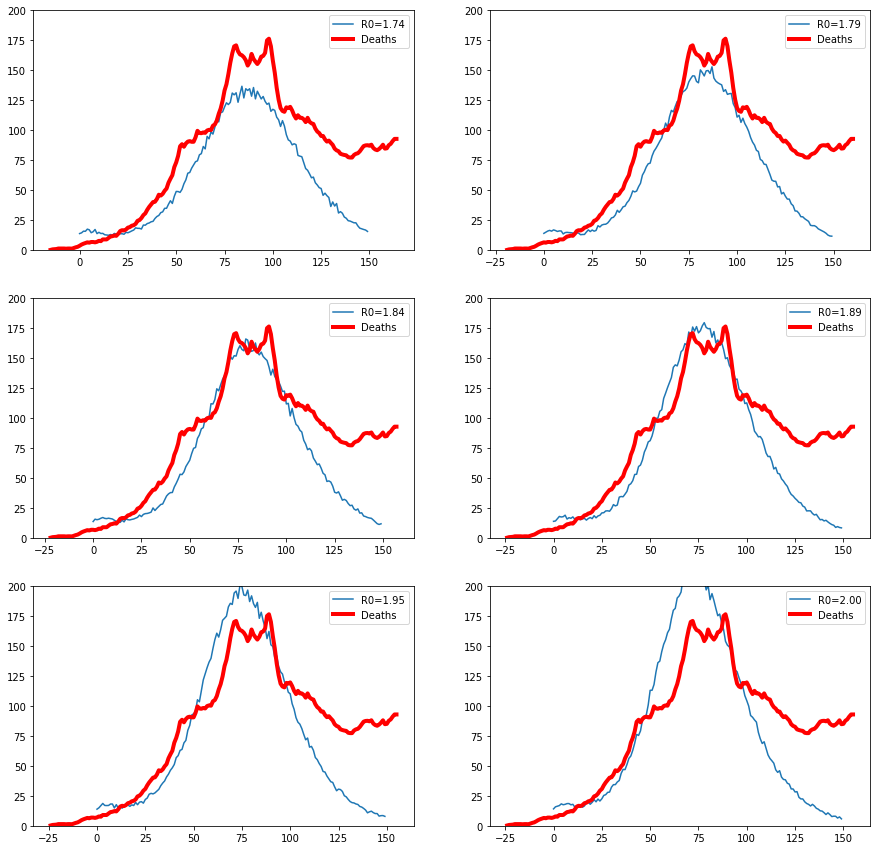

In [8]:
N,M = 3,2
fig, axs = plt.subplots(N,M,figsize=(15,15))
axs = [axs[i,j] for i in range(N) for j in range(M)]
lns = []
x = np.array(list(range(180)))
for i,R0,ax in zip(range(20)[20-N*M:], np.linspace(1.0, 2.0, 20)[20-N*M:], axs):
    death, Is, _ = get_inf_curve(f"../../output/R0_K2/{i}.txt", death = (death_ratio**1)*10)
    #death, Is, _ = get_inf_curve2(f"../../output/R0_K2/{i}.txt", death_ratio = (death_ratio**1), all_death = np.sum(death_orig))
    ax.plot(x[:len(death)], death, label=f"R0={R0:.2f}")
    
    shift, l2 = fit(death_orig, death)
    print(f"R0={R0:.2f} ==> Optimal shift: {shift} (l2 = {l2})")

    ln = ax.plot(x-shift, death_orig, c = 'r', label="Deaths", linewidth=4)
    ax.set_ylim(0,200)
    ax.legend()

R0=1.53 ==> Optimal shift: 0 (l2 = 563.07172794448)
R0=1.58 ==> Optimal shift: 4 (l2 = 511.01147307465715)
R0=1.63 ==> Optimal shift: 10 (l2 = 459.7882617109829)
R0=1.68 ==> Optimal shift: 11 (l2 = 407.714569061679)
R0=1.74 ==> Optimal shift: 15 (l2 = 385.7316748960649)
R0=1.79 ==> Optimal shift: 19 (l2 = 373.62207711679235)
R0=1.84 ==> Optimal shift: 22 (l2 = 370.1737642149865)
R0=1.89 ==> Optimal shift: 24 (l2 = 401.6959461616061)
R0=1.95 ==> Optimal shift: 24 (l2 = 445.7281255186971)
R0=2.00 ==> Optimal shift: 24 (l2 = 501.77630040062024)


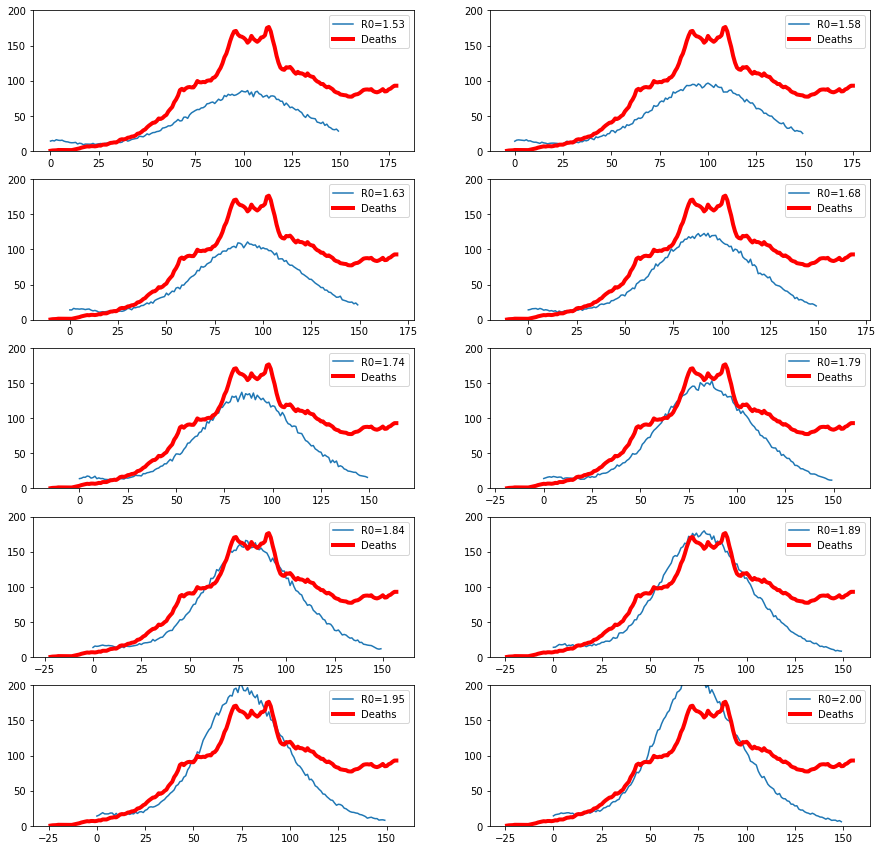

In [9]:
N,M = 5,2
fig, axs = plt.subplots(N,M,figsize=(15,15))
axs = [axs[i,j] for i in range(N) for j in range(M)]
lns = []
x = np.array(list(range(180)))
for i,R0,ax in zip(range(20)[20-N*M:], np.linspace(1.0, 2.0, 20)[20-N*M:], axs):
    death, Is, _ = get_inf_curve(f"../../output/R0_K2/{i}.txt", death = (death_ratio**1)*10)
    ax.plot(x[:len(death)], death, label=f"R0={R0:.2f}")
    
    shift, l2 = fit(death_orig, death)
    print(f"R0={R0:.2f} ==> Optimal shift: {shift} (l2 = {l2})")

    ln = ax.plot(x-shift, death_orig, c = 'r', label="Deaths", linewidth=4)
    ax.set_ylim(0,200)
    ax.legend()

base ==> Optimal shift: 24 (l2 = 1262.9641221587547)


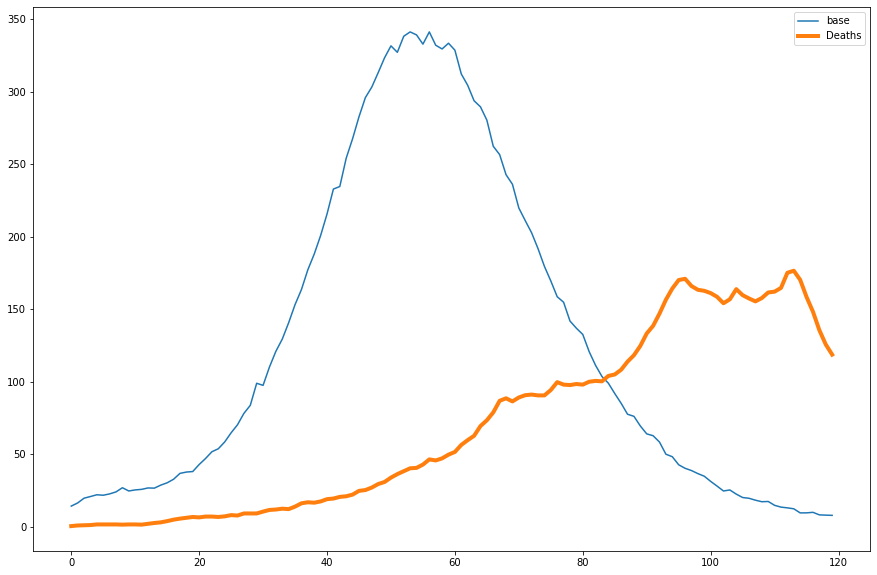

In [5]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/base", death = death_ratio*10)
x = np.array(list(range(len(death))))
ax.plot(x, death, label=f"base")

shift, l2 = fit(death_orig, death)
print(f"base ==> Optimal shift: {shift} (l2 = {l2})")

lns1 = ax.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)
plt.legend()
plt.show()

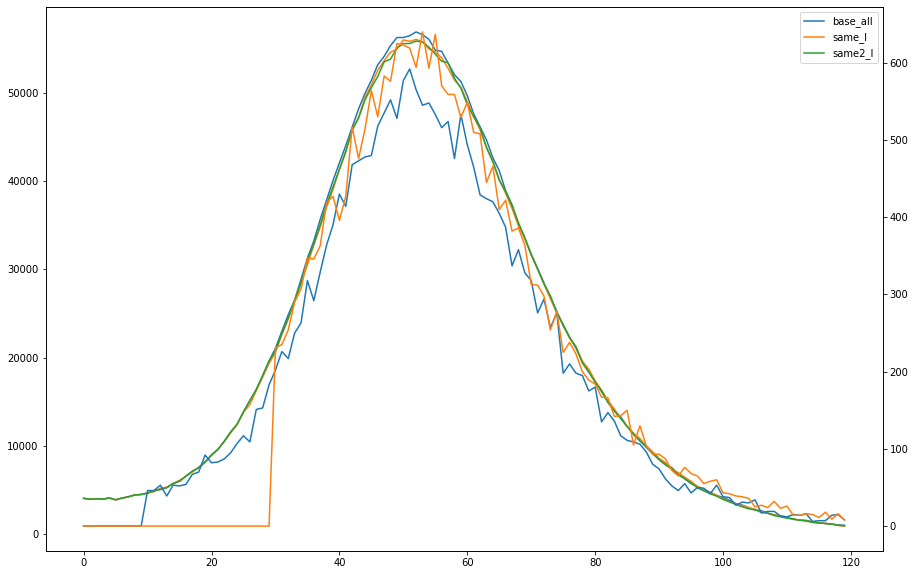

In [6]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
ax2 = ax.twinx()
death, Is, Is2 = get_inf_curve(f"../../output/second_wave/base", death = death_ratio*10)
x = np.array(list(range(len(death))))
#ax.plot(x, Is, label=f"base_I")
#ax.plot(x, Is2, label=f"base_I2")
ax.plot(x, Is+Is2, label=f"base_all")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/same", death = death_ratio*10)
x = np.array(list(range(len(death))))
ax.plot(x, Is, label=f"same_I")
ax2.plot(x, Is2, label=f"same_I2")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/same2", death = death_ratio*10)
x = np.array(list(range(len(death))))
ax.plot(x, Is, label=f"same2_I")
ax2.plot(x, Is2, label=f"same2_I2")

ax.legend()

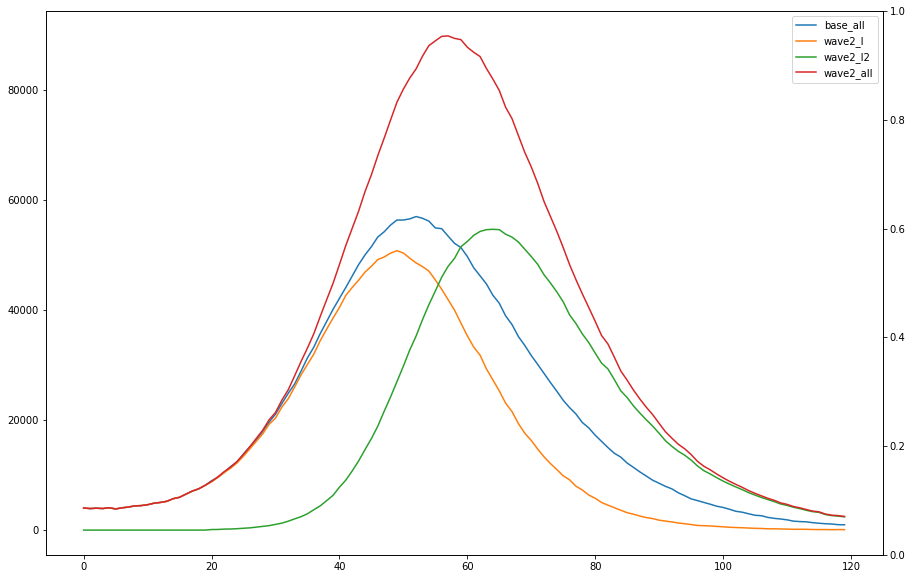

In [9]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
ax2 = ax.twinx()
death, Is, Is2 = get_inf_curve(f"../../output/second_wave/base", death = death_ratio*10)
x = np.array(list(range(len(death))))
ax.plot(x, Is+Is2, label=f"base_all")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_20_2.0", death = death_ratio*10)
x = np.array(list(range(len(death))))
ax.plot(x, Is, label=f"wave2_I")
ax.plot(x, Is2, label=f"wave2_I2")
ax.plot(x, Is+Is2, label=f"wave2_all")

ax.legend()

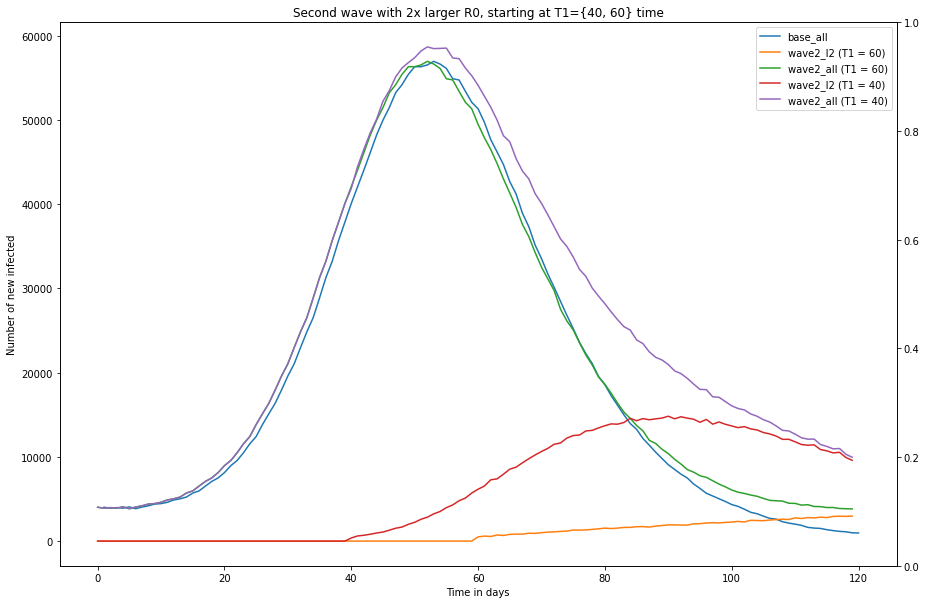

In [29]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
ax2 = ax.twinx()
death, Is, Is2 = get_inf_curve(f"../../output/second_wave/base", death = death_ratio*10)
x = np.array(list(range(1, len(death)+1)))
ax.plot(x, Is+Is2, label=f"base_all")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_60_2.0", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (T1 = 60)")
ax.plot(x, Is+Is2, label=f"wave2_all (T1 = 60)")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_40_2.0", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (T1 = 40)")
ax.plot(x, Is+Is2, label=f"wave2_all (T1 = 40)")

ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("Second wave with 2x larger R0, starting at T1={40, 60} time")
plt.show()

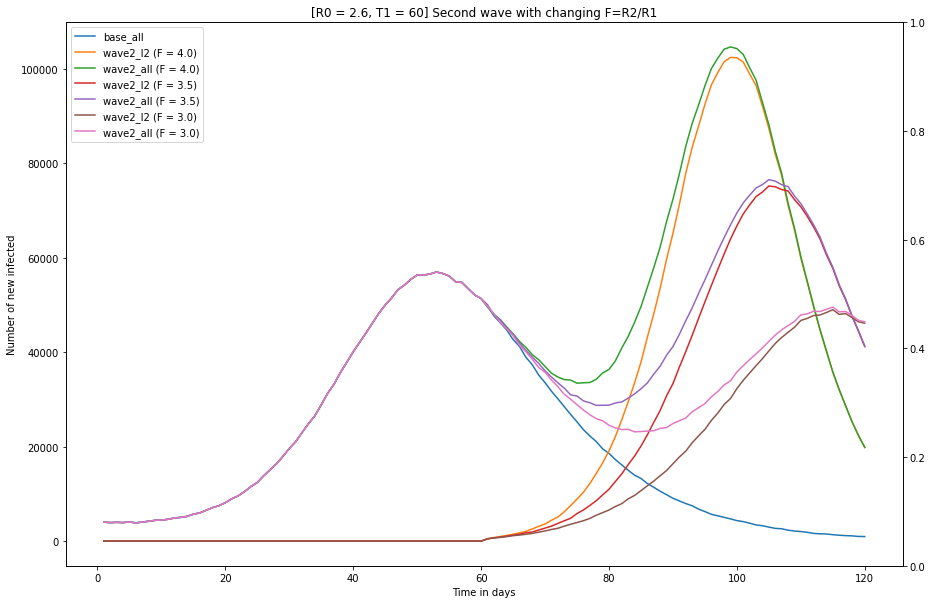

In [7]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
ax2 = ax.twinx()
death, Is, Is2 = get_inf_curve(f"../../output/second_wave/base", death = death_ratio*10)
x = np.array(list(range(1, len(death)+1)))
ax.plot(x, Is+Is2, label=f"base_all")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_60_4.0", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (F = 4.0)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 4.0)")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_60_3.5", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (F = 3.5)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 3.5)")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_60_3.0", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (F = 3.0)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 3.0)")



ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("[R0 = 2.6, T1 = 60] Second wave with changing F=R2/R1")
plt.show()

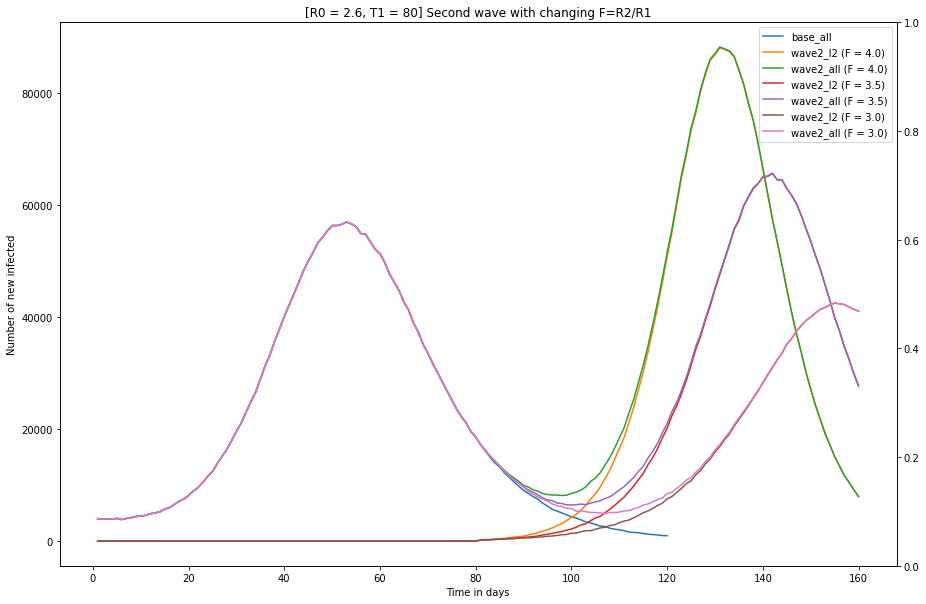

In [6]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
ax2 = ax.twinx()
death, Is, Is2 = get_inf_curve(f"../../output/second_wave/base", death = death_ratio*10)
x = np.array(list(range(1, len(death)+1)))
ax.plot(x, Is+Is2, label=f"base_all")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_80_4.0", death = death_ratio*10)
x = np.array(list(range(1, len(death)+1)))
ax.plot(x, Is2, label=f"wave2_I2 (F = 4.0)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 4.0)")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_80_3.5", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (F = 3.5)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 3.5)")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_80_3.0", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (F = 3.0)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 3.0)")



ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("[R0 = 2.6, T1 = 80] Second wave with changing F=R2/R1")
plt.show()

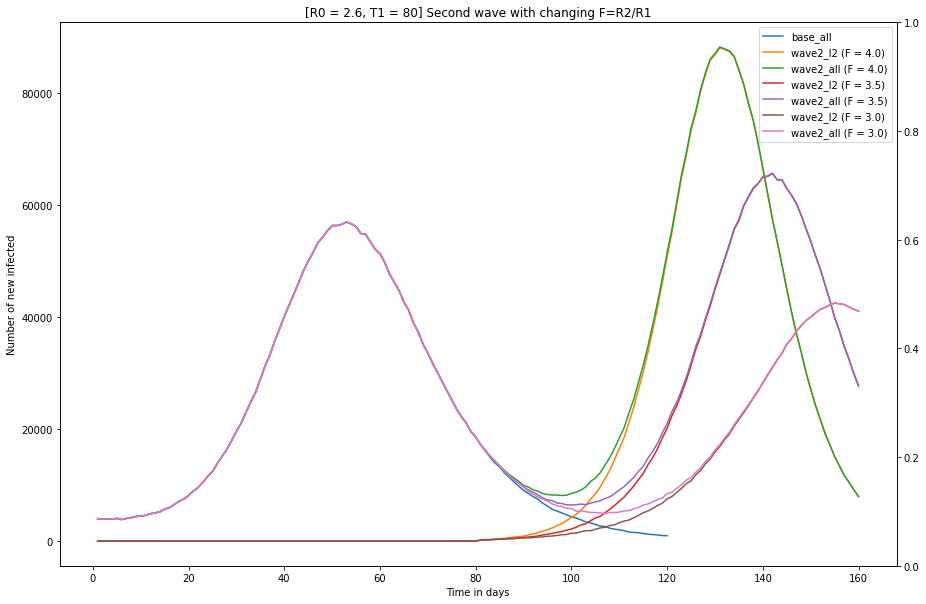

In [8]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
ax2 = ax.twinx()
death, Is, Is2 = get_inf_curve(f"../../output/second_wave/base", death = death_ratio*10)
x = np.array(list(range(1, len(death)+1)))
ax.plot(x, Is+Is2, label=f"base_all")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_80_4.0", death = death_ratio*10)
x = np.array(list(range(1, len(death)+1)))
ax.plot(x, Is2, label=f"wave2_I2 (F = 4.0)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 4.0)")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_80_3.5", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (F = 3.5)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 3.5)")

death, Is, Is2 = get_inf_curve(f"../../output/second_wave/second_80_3.0", death = death_ratio*10)
ax.plot(x, Is2, label=f"wave2_I2 (F = 3.0)")
ax.plot(x, Is+Is2, label=f"wave2_all (F = 3.0)")



ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("[R0 = 2.6, T1 = 80] Second wave with changing F=R2/R1")
plt.show()

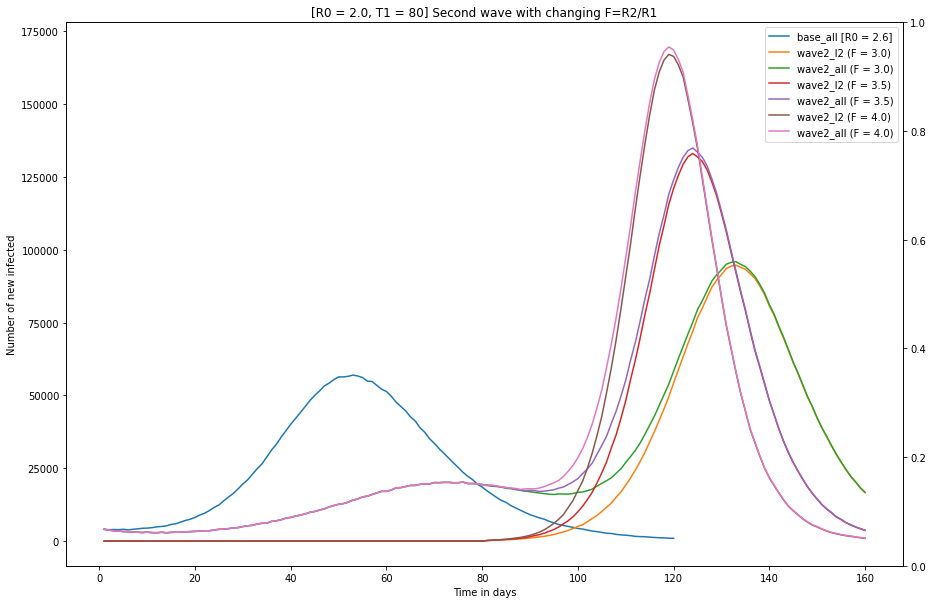

In [9]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
ax2 = ax.twinx()
death, Is, Is2 = get_inf_curve(f"../../output/second_wave/base", death = death_ratio*10)
x = np.array(list(range(1, len(death)+1)))
ax.plot(x, Is+Is2, label=f"base_all [R0 = 2.6]")

measure = "second_wave/second_T1:80_R0:2.0"
for i,F in enumerate([3.0, 3.5, 4.0]):

    death, Is, Is2 = get_inf_curve(f"../../output/{measure}/{i}.txt", death = death_ratio*10)
    x = np.array(list(range(1, len(death)+1)))
    ax.plot(x, Is2, label=f"wave2_I2 (F = {F})")
    ax.plot(x, Is+Is2, label=f"wave2_all (F = {F})")


ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("[R0 = 2.0, T1 = 80] Second wave with changing F=R2/R1")
plt.show()

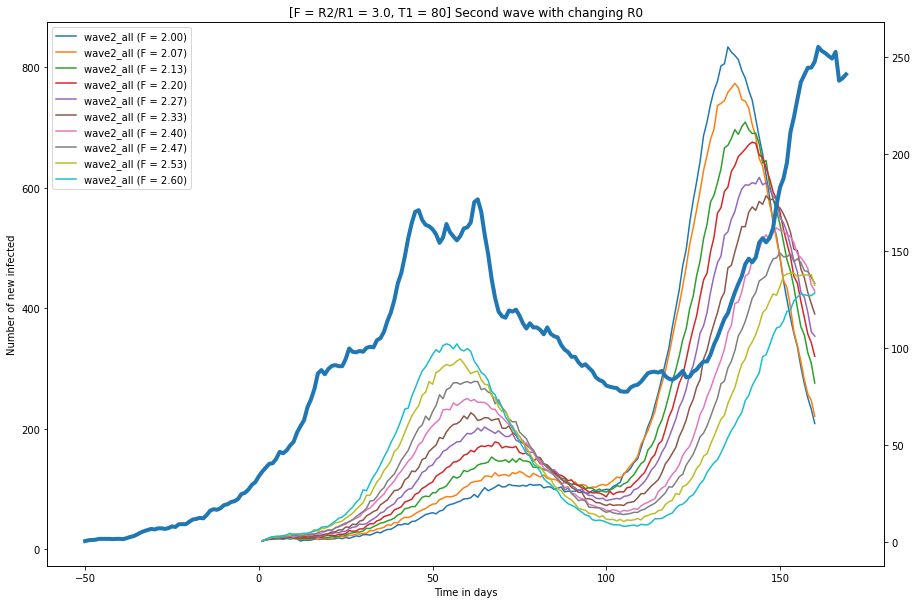

In [36]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs

measure = "second_wave/second_T1:80_F:3.0"
for i,F in enumerate(np.linspace(2.0, 2.6, 10)):

    death, Is, Is2 = get_inf_curve(f"../../output/{measure}/{i}.txt", death = death_ratio*10)
    x = np.array(list(range(1, len(death)+1)))
    #ax.plot(x, Is2, label=f"wave2_I2 (F = {F:.2f})")
    #ax.plot(x, Is+Is2, label=f"wave2_all (F = {F:.2f})")
    ax.plot(x, death, label=f"wave2_all (F = {F:.2f})")

x = np.array(range(-50, 220-50))
ax2 = ax.twinx()
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = ax2.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)

ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("[F = R2/R1 = 3.0, T1 = 80] Second wave with changing R0")
plt.show()

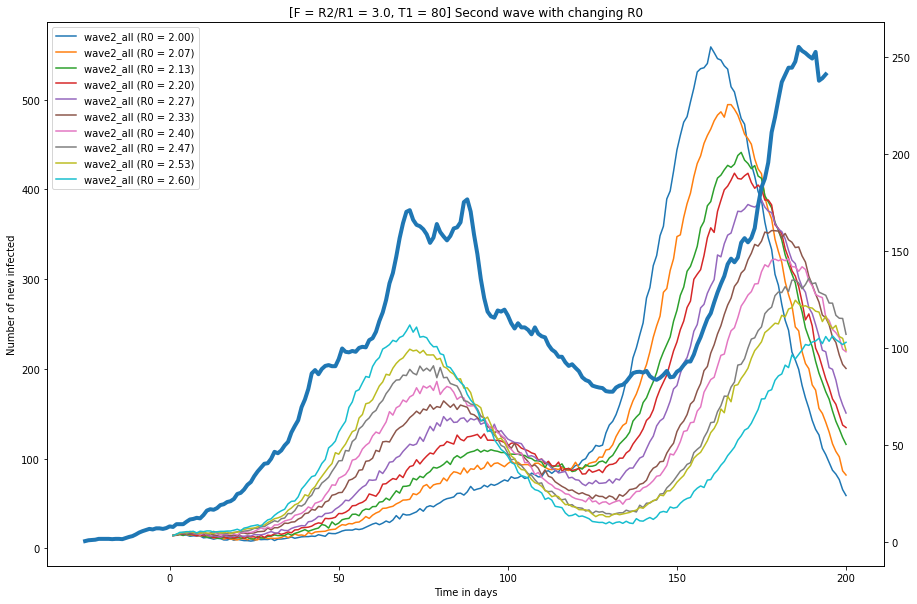

In [86]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs

measure = "second_wave/second_T1:100_F:2.5_s:0.25"
for i,F in enumerate(np.linspace(2.0, 2.6, 10)):

    death, Is, Is2 = get_inf_curve(f"../../output/{measure}/{i}.txt", death = death_ratio*10)
    x = np.array(list(range(1, len(death)+1)))
    #ax.plot(x, Is2, label=f"wave2_I2 (F = {F:.2f})")
    #ax.plot(x, Is+Is2, label=f"wave2_all (F = {F:.2f})")
    ax.plot(x, death, label=f"wave2_all (R0 = {F:.2f})")

x = np.array(range(-25, 220-25))
ax2 = ax.twinx()
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = ax2.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)

ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("[F = R2/R1 = 3.0, T1 = 80] Second wave with changing R0")
plt.show()

Text(0, 0.5, 'Deaths')

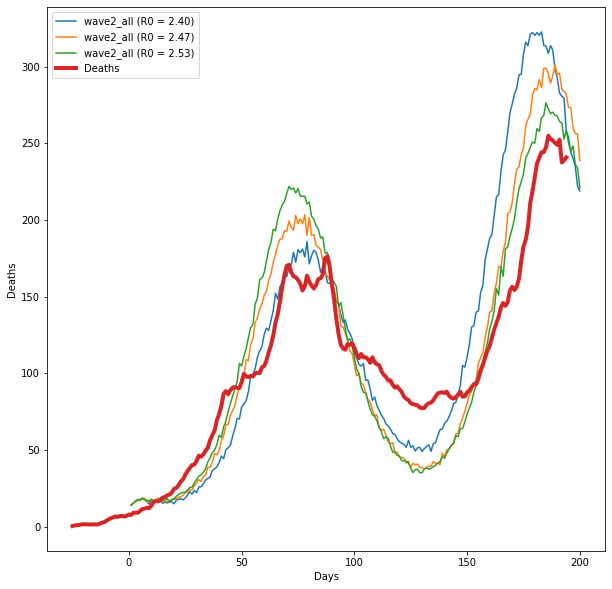

In [95]:
plt.figure(figsize=(10,10))
measure = "second_wave/second_T1:100_F:2.5_s:0.25"
R0 = np.linspace(2.0, 2.6, 10)
for i in [6,7,8]:
    death, Is, Is2 = get_inf_curve(f"../../output/{measure}/{i}.txt", death = death_ratio*10)
    x = np.array(list(range(1, len(death)+1)))
    #ax.plot(x, Is2, label=f"wave2_I2 (F = {F:.2f})")
    #ax.plot(x, Is+Is2, label=f"wave2_all (F = {F:.2f})")
    plt.plot(x, death, label=f"wave2_all (R0 = {R0[i]:.2f})")

x = np.array(range(-25, 220-25))
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = plt.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)
plt.legend()
plt.xlabel('Days')
plt.ylabel("Deaths")

In [157]:
i,measure = 6,"second_wave/second_T1:100_F:2.5_s:0.25"
filename = f"../../output/{measure}/{i}.txt"
df = pd.read_csv(filename, sep=',')

def get_time_and_age_agg(city, second=False):
    I = 'I2' if second else 'I_'
    inf_cols = [c for c in df.columns if (c[0:2]==I) and int(c.split('_')[1])==city]
    return df[inf_cols].sum(1), df[inf_cols].sum(0), inf_cols

def get_age_group(city, age_group, second=False):
    I = f'I_{city}_{age_group}'
    I2 = f'I2_{city}_{age_group}'
    return df[[I,I2]].sum(1)

In [178]:
pops = json.load(open("../../input/hun/populations_KSH.json"))['populations']
pops = {int(p['name']): p for p in pops}

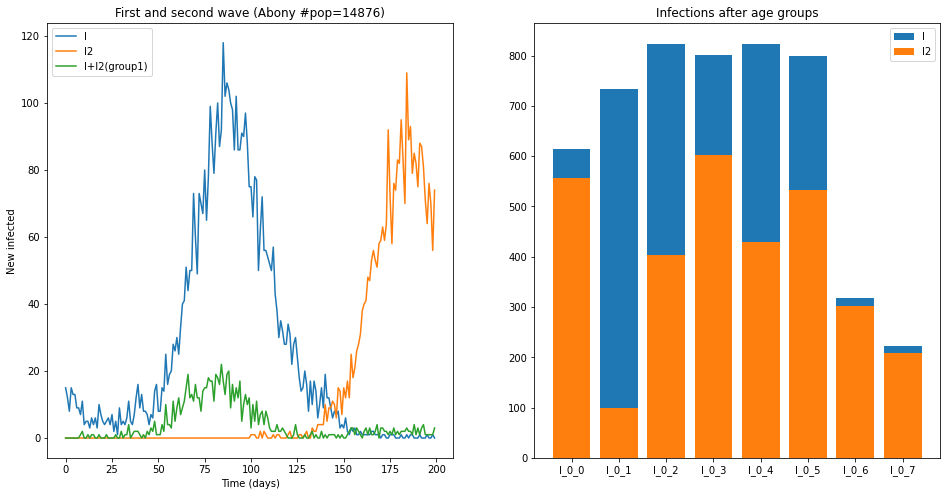

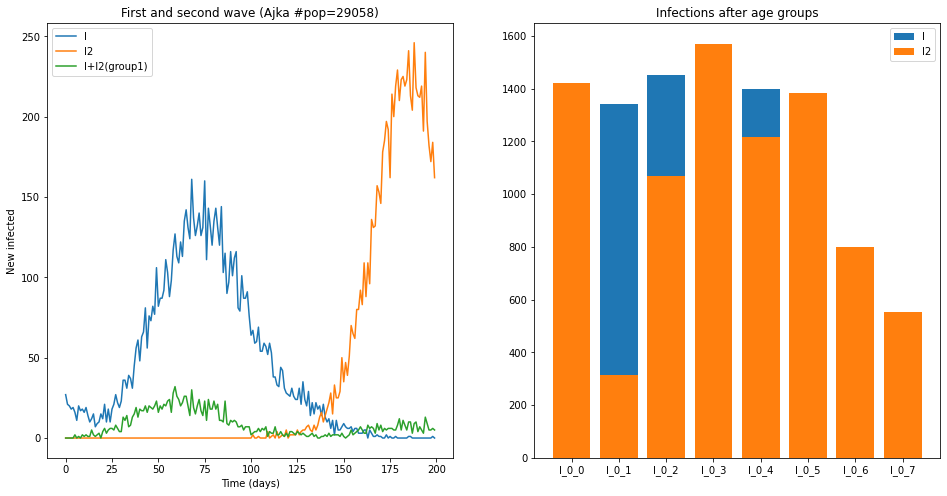

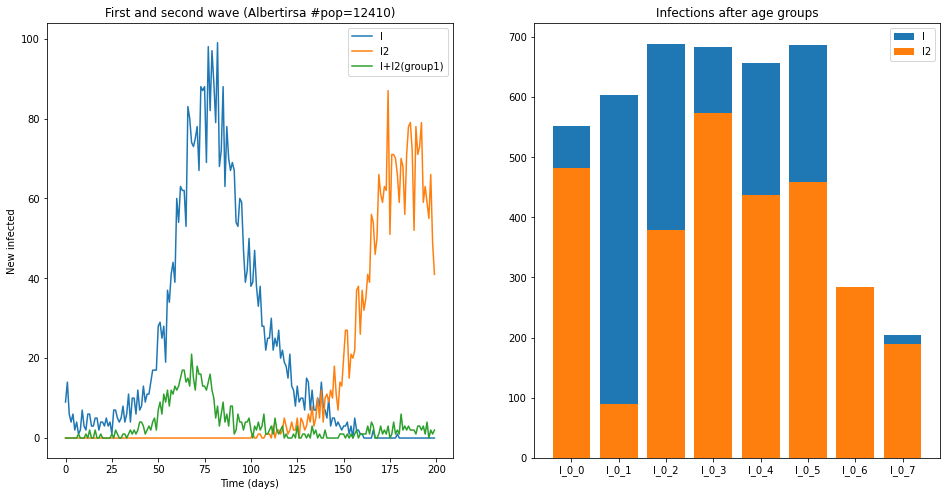

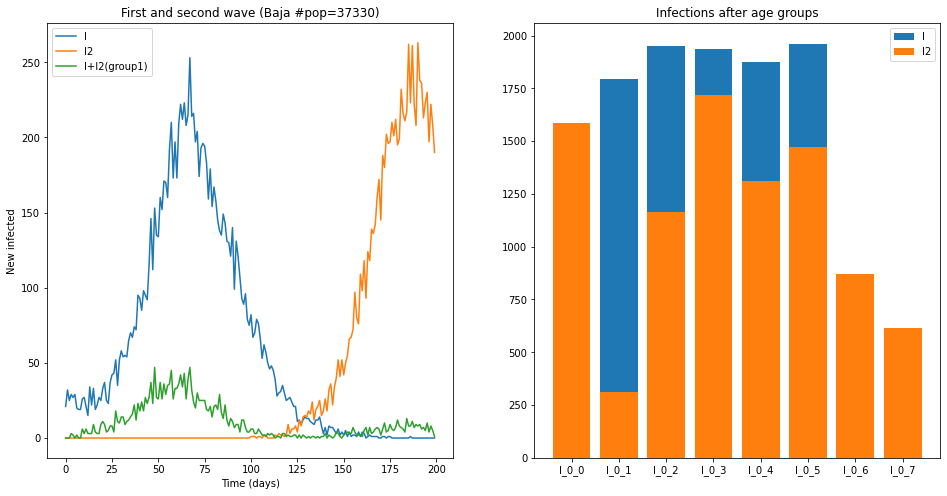

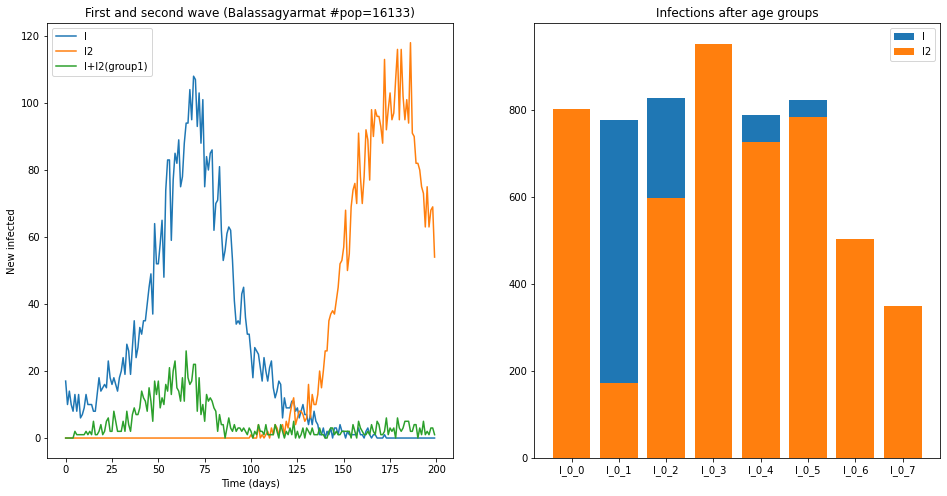

In [182]:
for city in range(5):
    time, age, name = get_time_and_age_agg(city, second=False)
    group1 = get_age_group(city, 1)
    time2, age2, name2 = get_time_and_age_agg(city, second=True)
    

    fig, axs = plt.subplots(1,2, figsize=(16,8))
    axs[0].plot(time, label="I")
    axs[0].plot(time2, label="I2")
    axs[0].plot(group1, label="I+I2(group1)")
    axs[0].set_title(f"First and second wave ({pops[city]['city']} #pop={pops[city]['N']})")
    axs[0].set_xlabel("Time (days)")
    axs[0].set_ylabel("New infected")
    axs[0].legend()

    axs[1].bar(inf_cols, age, label="I")
    axs[1].bar(inf_cols, age2, label="I2")
    axs[1].set_title("Infections after age groups")
    axs[1].legend()

    plt.show()

In [201]:
big_cities_ind = [k for k,v in pops.items() if v['city'] in ['Budakeszi', 'Debrecen', "Szeged", "Kecskemét", "Győr"] ]

bp_kers = [f"Budapest 0{i}. ker." for i in range(10)]+[f"Budapest {i}. ker." for i in range(11, 24)]
bp_ind = [k for k,v in pops.items() if v['city'] in bp_kers ]

medium_cities = [k for k,v in pops.items() if (v['N'] < 20000)]

In [202]:
len(medium_cities)

87

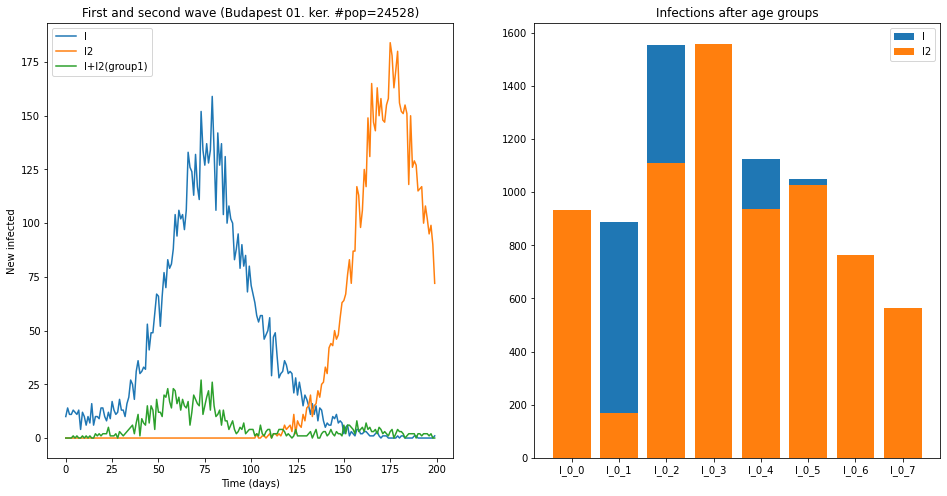

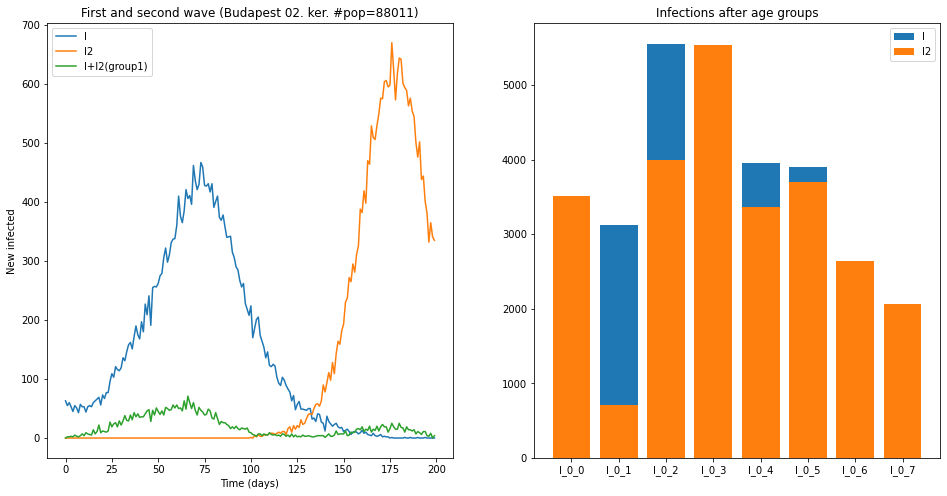

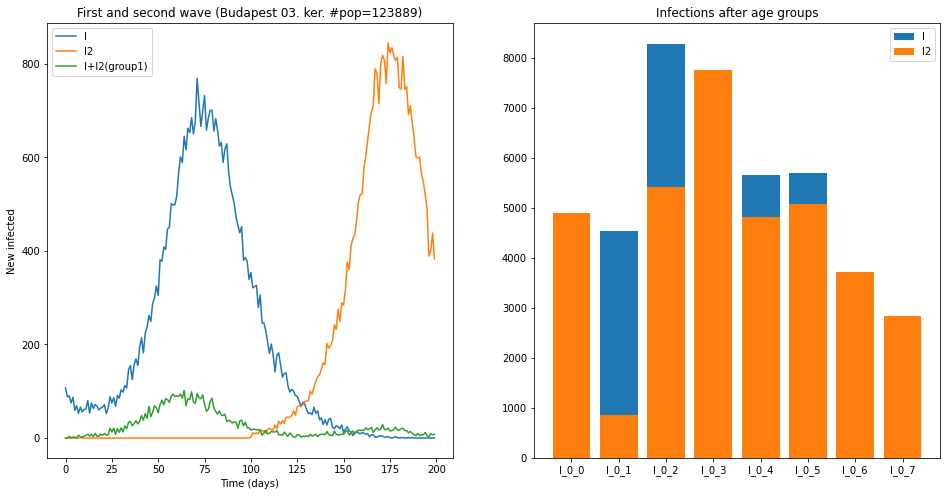

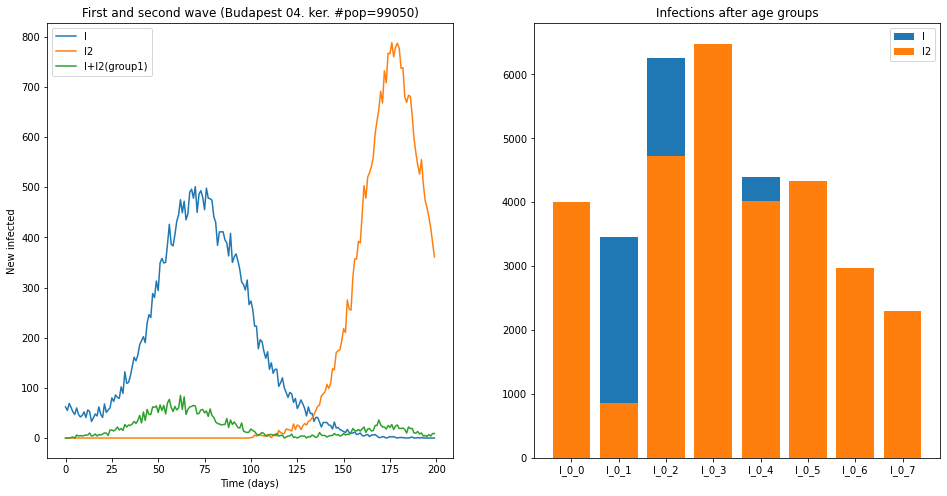

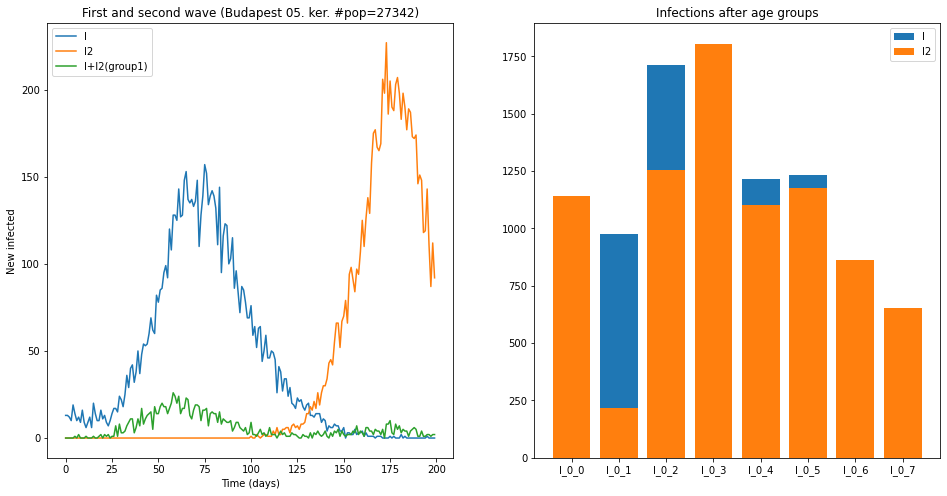

In [195]:
for city in bp_ind[:5]:
    time, age, name = get_time_and_age_agg(city, second=False)
    group1 = get_age_group(city, 1)
    time2, age2, name2 = get_time_and_age_agg(city, second=True)
    

    fig, axs = plt.subplots(1,2, figsize=(16,8))
    axs[0].plot(time, label="I")
    axs[0].plot(time2, label="I2")
    axs[0].plot(group1, label="I+I2(group1)")
    axs[0].set_title(f"First and second wave ({pops[city]['city']} #pop={pops[city]['N']})")
    axs[0].set_xlabel("Time (days)")
    axs[0].set_ylabel("New infected")
    axs[0].legend()

    axs[1].bar(inf_cols, age, label="I")
    axs[1].bar(inf_cols, age2, label="I2")
    axs[1].set_title("Infections after age groups")
    axs[1].legend()

    plt.show()

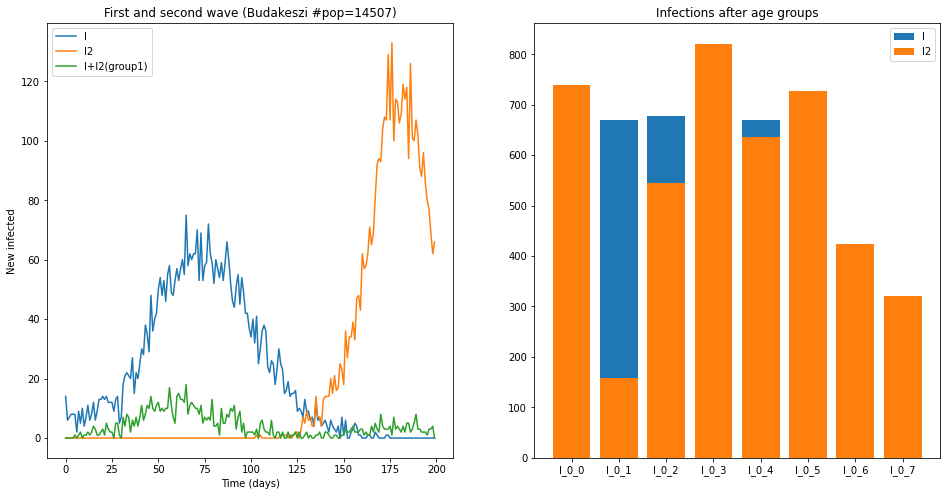

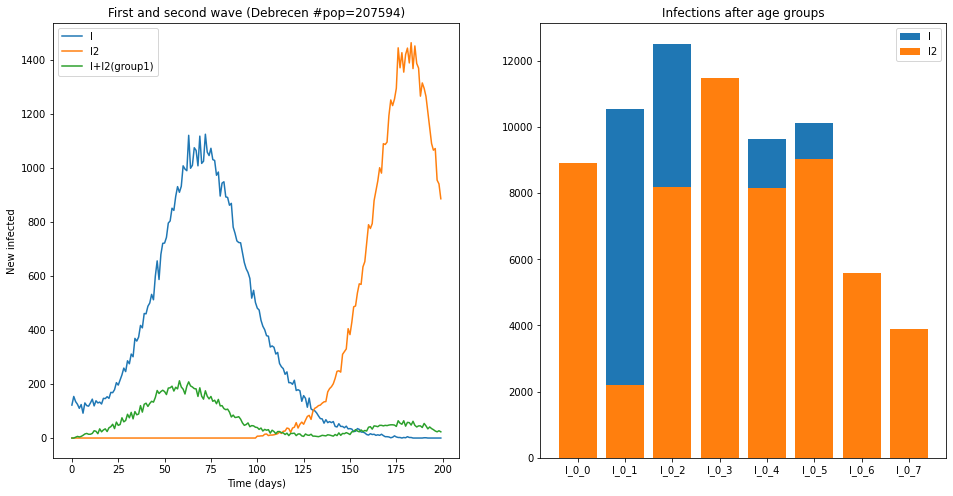

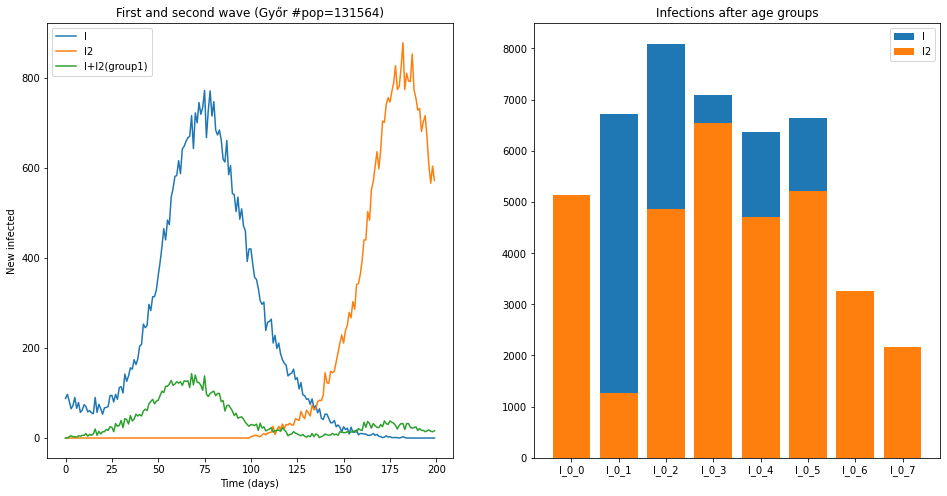

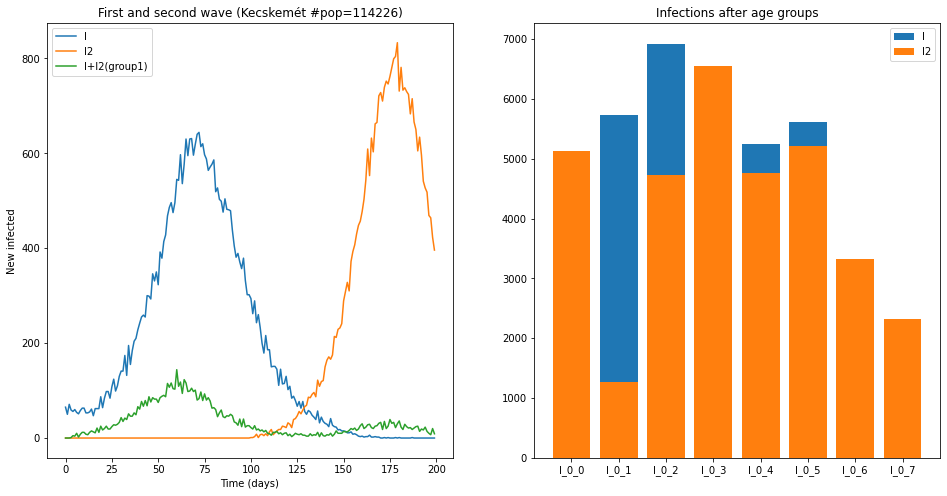

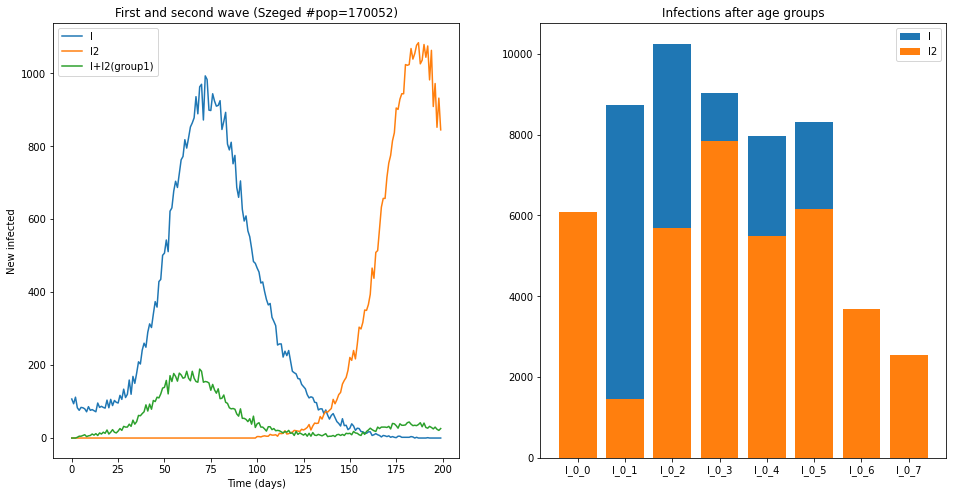

In [193]:
for city in big_cities_ind:
    time, age, name = get_time_and_age_agg(city, second=False)
    group1 = get_age_group(city, 1)
    time2, age2, name2 = get_time_and_age_agg(city, second=True)
    

    fig, axs = plt.subplots(1,2, figsize=(16,8))
    axs[0].plot(time, label="I")
    axs[0].plot(time2, label="I2")
    axs[0].plot(group1, label="I+I2(group1)")
    axs[0].set_title(f"First and second wave ({pops[city]['city']} #pop={pops[city]['N']})")
    axs[0].set_xlabel("Time (days)")
    axs[0].set_ylabel("New infected")
    axs[0].legend()

    axs[1].bar(inf_cols, age, label="I")
    axs[1].bar(inf_cols, age2, label="I2")
    axs[1].set_title("Infections after age groups")
    axs[1].legend()

    plt.show()

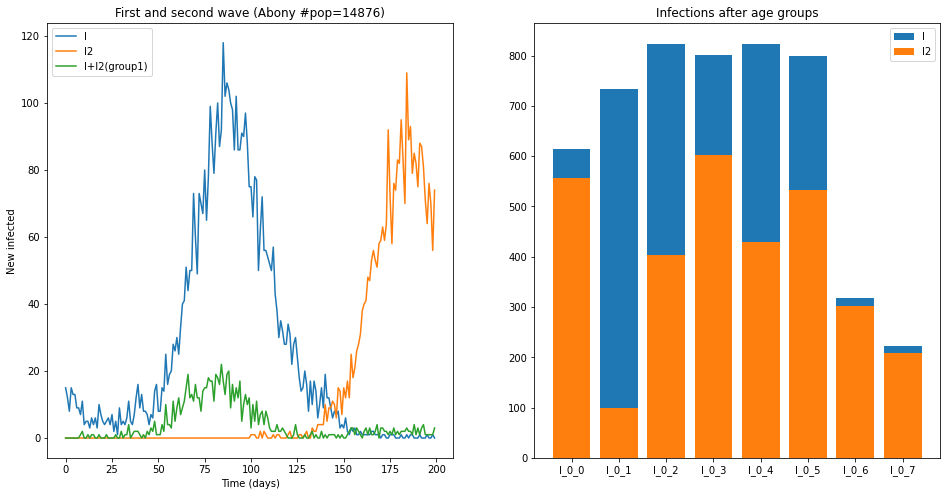

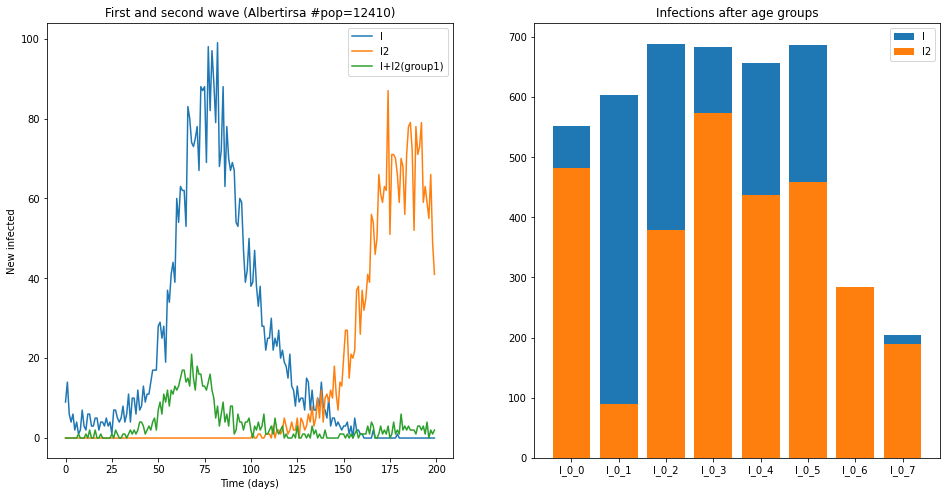

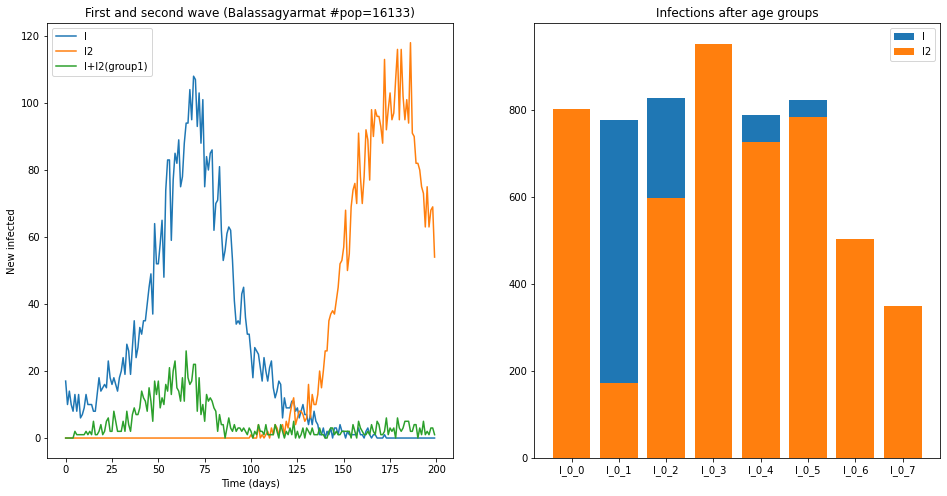

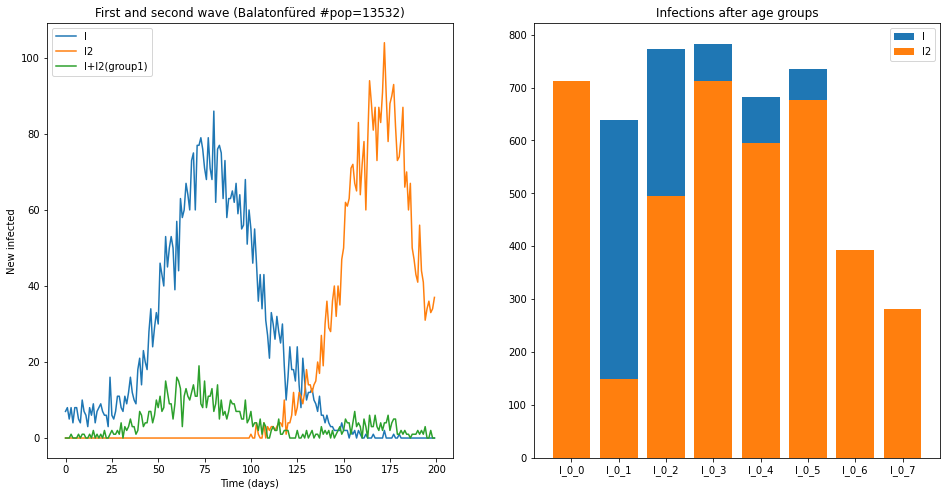

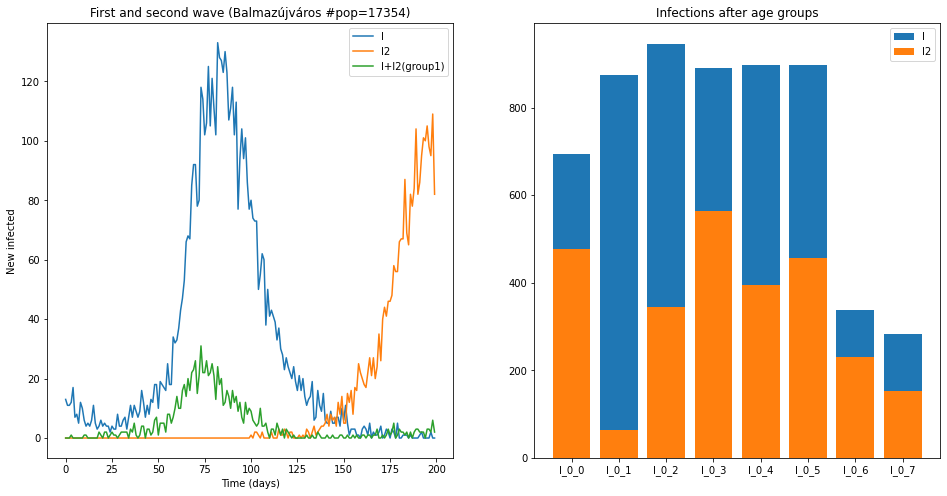

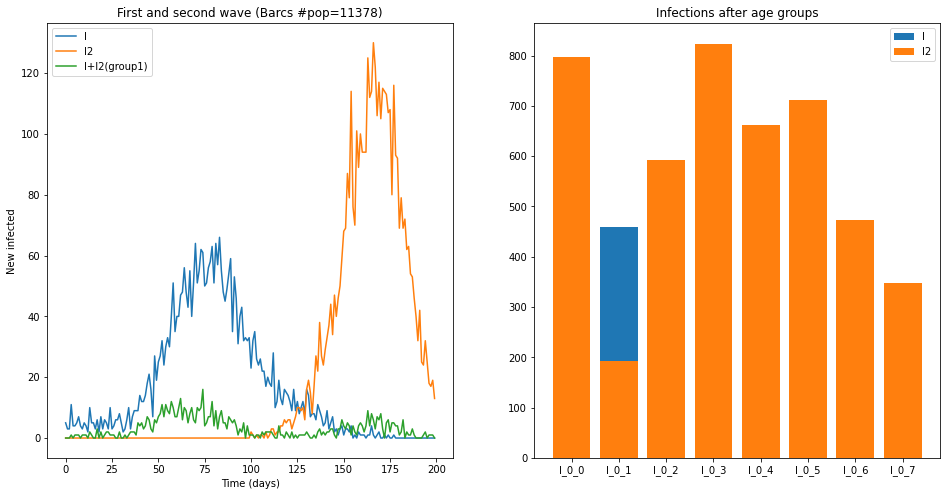

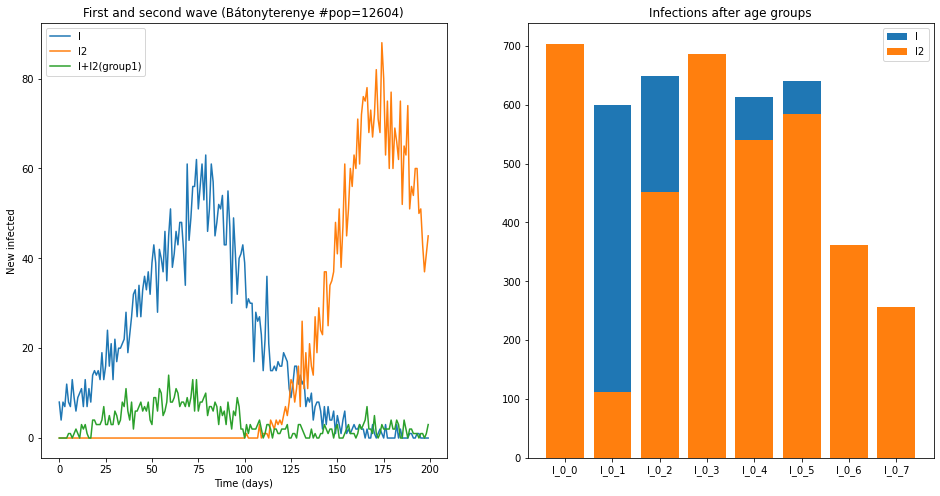

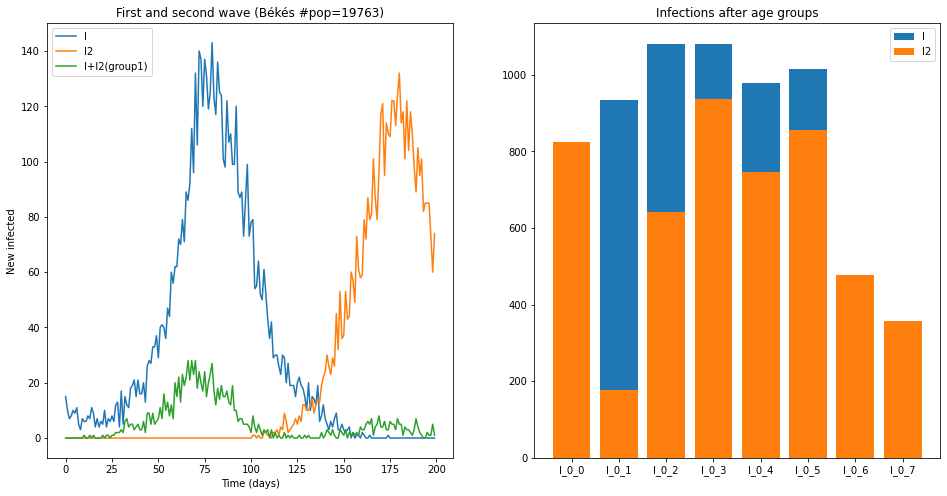

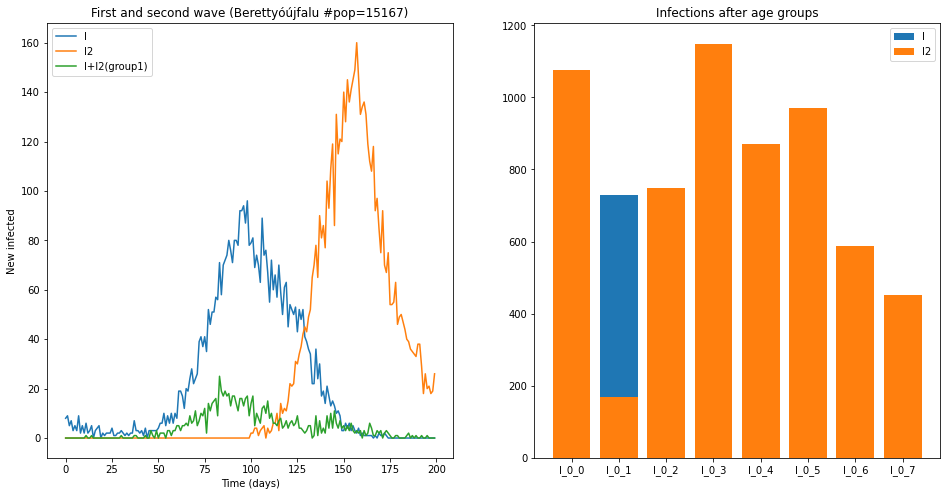

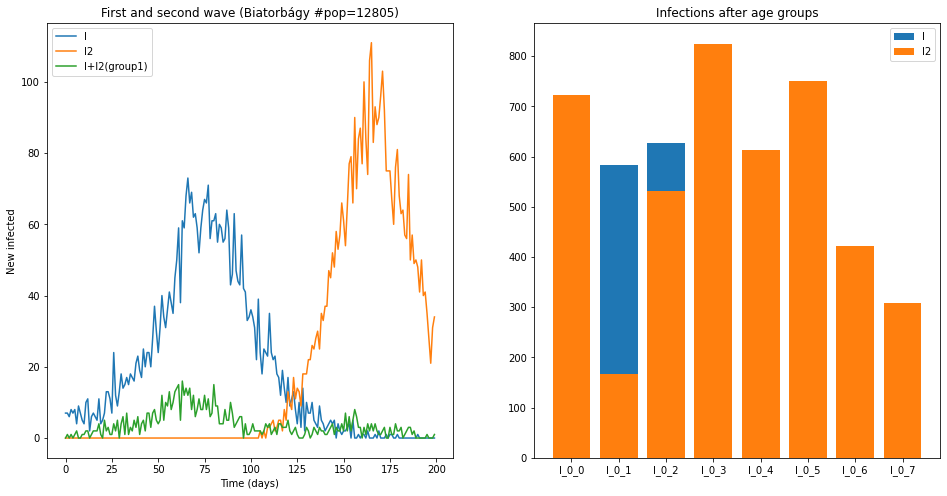

In [206]:
for city in medium_cities[:10]:
    time, age, name = get_time_and_age_agg(city, second=False)
    group1 = get_age_group(city, 1)
    time2, age2, name2 = get_time_and_age_agg(city, second=True)
    

    fig, axs = plt.subplots(1,2, figsize=(16,8))
    axs[0].plot(time, label="I")
    axs[0].plot(time2, label="I2")
    axs[0].plot(group1, label="I+I2(group1)")
    axs[0].set_title(f"First and second wave ({pops[city]['city']} #pop={pops[city]['N']})")
    axs[0].set_xlabel("Time (days)")
    axs[0].set_ylabel("New infected")
    axs[0].legend()

    axs[1].bar(inf_cols, age, label="I")
    axs[1].bar(inf_cols, age2, label="I2")
    axs[1].set_title("Infections after age groups")
    axs[1].legend()

    plt.show()

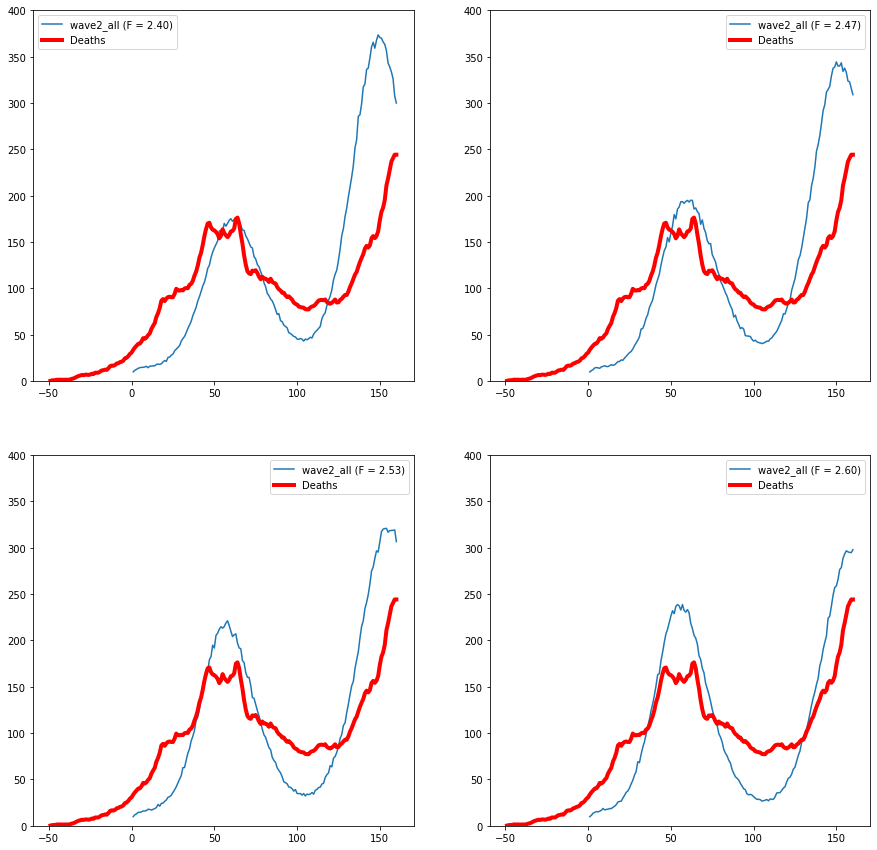

In [61]:
N,M = 2,2
fig, axs = plt.subplots(N,M,figsize=(15,15))
axs = [axs[i,j] for i in range(N) for j in range(M)]
lns = []


death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
measure = "second_wave/second_T1:80_F:3.0"
#for (i,F),ax in zip(enumerate(np.linspace(2.0, 2.6, 10)), axs):
for i,F,ax in zip(range(6,10), np.linspace(2.0, 2.6, 10)[-4:], axs):

    death, Is, Is2 = get_inf_curve(f"../../output/{measure}/{i}.txt", death = death_ratio*7)
    x = np.array(list(range(1, len(death)+1)))
    ax.plot(x, death, label=f"wave2_all (F = {F:.2f})")
    
    #shift, l2 = fit(death_orig, death)
    #print(f"R0={R0:.2f} ==> Optimal shift: {shift} (l2 = {l2})")
    shift=50
    x = np.array(list(range(1, len(death)+1+50)))
    ln = ax.plot(x-shift, death_orig[:len(x)], c = 'r', label="Deaths", linewidth=4)
    ax.set_ylim(0,400)
    ax.legend()
plt.show();

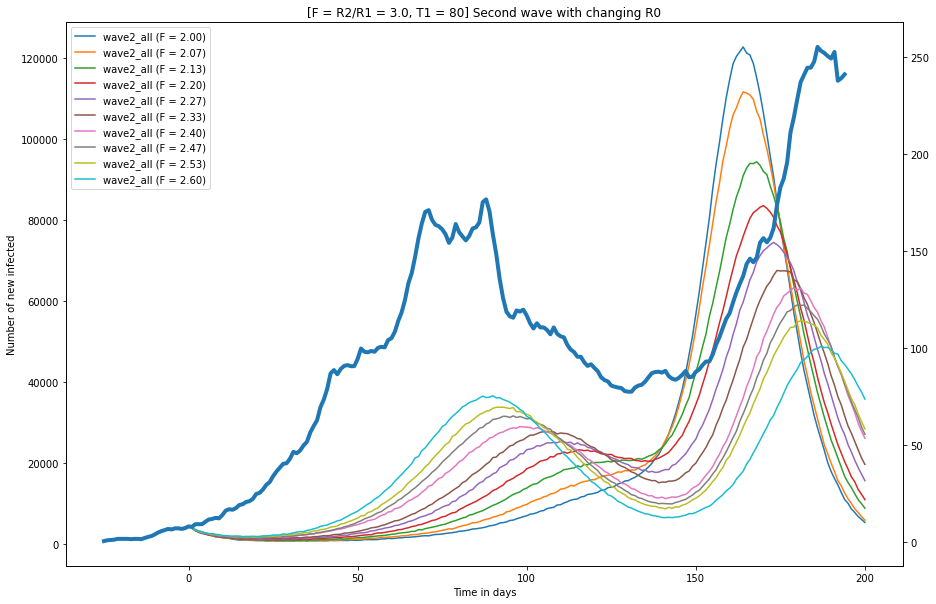

In [9]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
measure = "second_wave/second_T1:120_F:3.0_s:0.5"
for i,F in enumerate(np.linspace(2.0, 2.6, 10)):
    death, Is, Is2 = get_inf_curve(f"../../output/{measure}/{i}.txt", death = death_ratio*10)
    x = np.array(list(range(1, len(death)+1)))
    ax.plot(x, Is+Is2, label=f"wave2_all (F = {F:.2f})")

x = np.array(range(-25, 220-25))
ax2 = ax.twinx()
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = ax2.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)

ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("[F = R2/R1 = 3.0, T1 = 80] Second wave with changing R0")
plt.show()

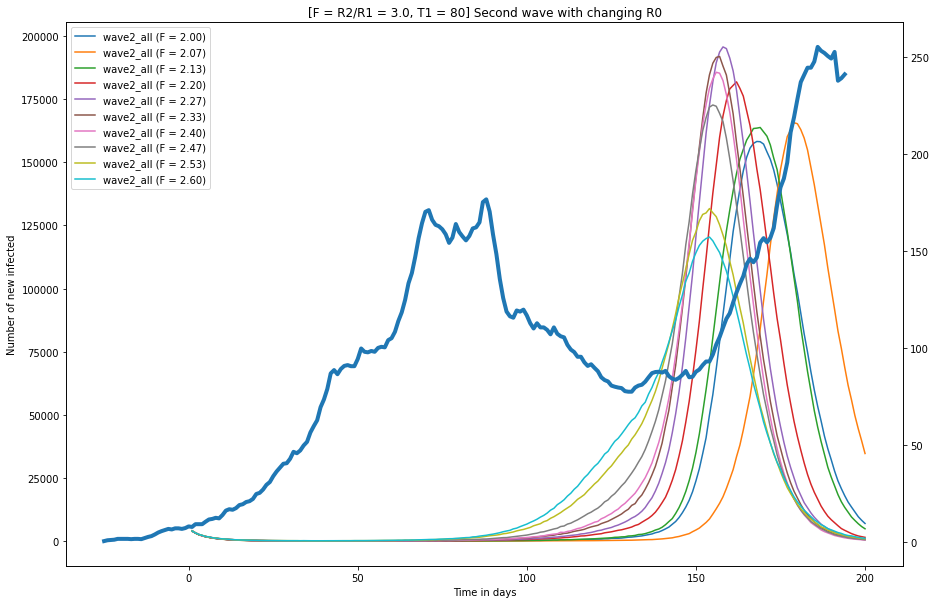

In [10]:
fig, axs = plt.subplots(1,1,figsize=(15,10))
ax = axs
measure = "second_wave/second_T1:120_F:3.0_s:1.0"
for i,F in enumerate(np.linspace(2.0, 2.6, 10)):
    death, Is, Is2 = get_inf_curve(f"../../output/{measure}/{i}.txt", death = death_ratio*10)
    x = np.array(list(range(1, len(death)+1)))
    ax.plot(x, Is+Is2, label=f"wave2_all (F = {F:.2f})")

x = np.array(range(-25, 220-25))
ax2 = ax.twinx()
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = ax2.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)

ax.legend()
ax.set_xlabel("Time in days")
ax.set_ylabel("Number of new infected")
ax.set_title("[F = R2/R1 = 3.0, T1 = 80] Second wave with changing R0")
plt.show()

# Compare City and District

In [9]:
d = json.load(open("../../input/hun_1000/populations_KSH.json"))
S = 0
for city in d["populations"]:
    S += city["N"]
print("Total pop [>1000]: ", S, "#city: ", len(d["populations"]))

d = json.load(open("../../input/hun_5000/populations_KSH.json"))
S = 0
for city in d["populations"]:
    S += city["N"]
print("Total pop [>5000]: ", S, "#city: ", len(d["populations"]))

"""
d = json.load(open("../../input/hun_5000/district/populations_KSH.json"))
S = 0
for city in d["populations"]:
    S += city["N"]
print("    Total pop (district): ", S)
"""

d = json.load(open("../../input/hun_10000/populations_KSH.json"))
S = 0
for city in d["populations"]:
    S += city["N"]
print("Total pop [>10000]: ", S, "#city: ", len(d["populations"]))

Total pop [>1000]:  9189357 #city:  1399
Total pop [>5000]:  6851674 #city:  294
Total pop [>10000]:  5978128 #city:  167


# KSH > 1000

Text(0.5, 1.0, 'KSH >1000')

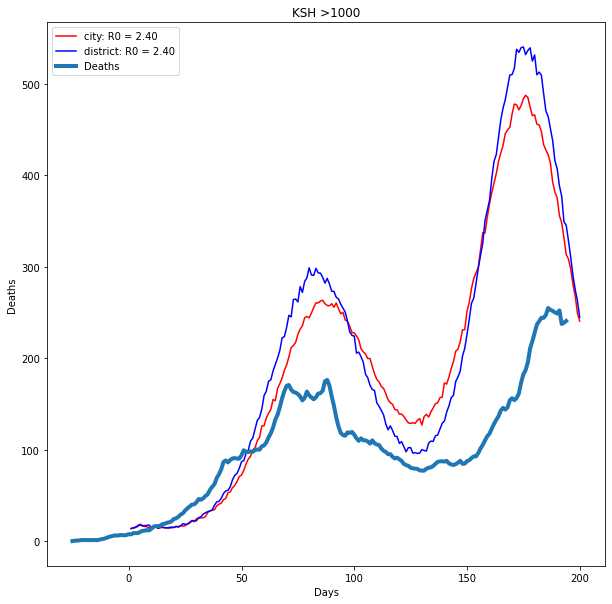

In [9]:
plt.figure(figsize=(10,10))
th = 1000
city = f"KSH_{th}/base"
district = f"KSH_{th}/district"

R0 = np.linspace(2.0, 2.6, 10)
for i in [6]:
    death, Is, Is2 = get_inf_curve(f"../../output/{city}/{i}.txt", death = death_ratio*10)
    death_d, Is_d, Is2_d = get_inf_curve(f"../../output/{district}/{i}.txt", death = death_ratio*10)
    
    x = np.array(list(range(1, len(death)+1)))
    plt.plot(x, death, label=f"city: R0 = {R0[i]:.2f}", c='r')
    plt.plot(x, death_d, label=f"district: R0 = {R0[i]:.2f}", c='b')

x = np.array(range(-25, 220-25))
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = plt.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)
plt.legend()
plt.xlabel('Days')
plt.ylabel("Deaths")
plt.title("KSH >1000")

## KSH > 5000

City has 4.31% less total infections


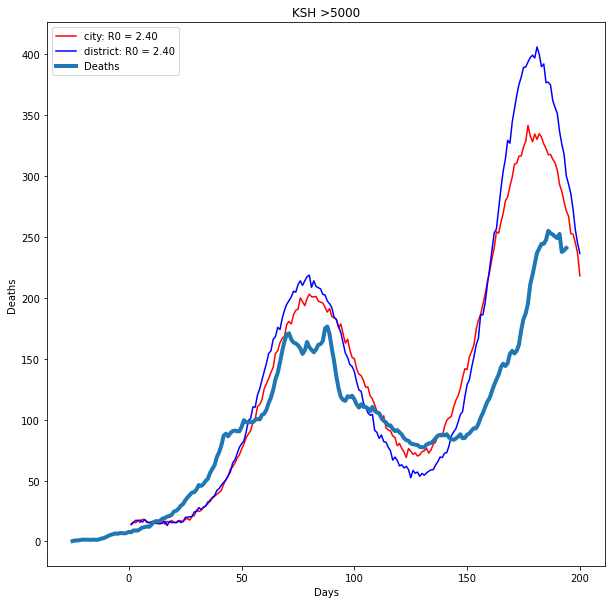

In [18]:
plt.figure(figsize=(10,10))
th = 5000
city = f"KSH_{th}/base"
district = f"KSH_{th}/district"

R0 = np.linspace(2.0, 2.6, 10)
for i in [6]:
    death, Is, Is2 = get_inf_curve(f"../../output/{city}/{i}.txt", death = death_ratio*10)
    death_d, Is_d, Is2_d = get_inf_curve(f"../../output/{district}/{i}.txt", death = death_ratio*10)
    
    x = np.array(list(range(1, len(death)+1)))
    plt.plot(x, death, label=f"city: R0 = {R0[i]:.2f}", c='r')
    plt.plot(x, death_d, label=f"district: R0 = {R0[i]:.2f}", c='b')

x = np.array(range(-25, 220-25))
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = plt.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)
plt.legend()
plt.xlabel('Days')
plt.ylabel("Deaths")
plt.title("KSH >5000")

print(f"City has {100-100*sum(death)/sum(death_d):.2f}% less total infections")

## KSH >10000

City has 1.77% less total infections
City has -2.15% less total infections


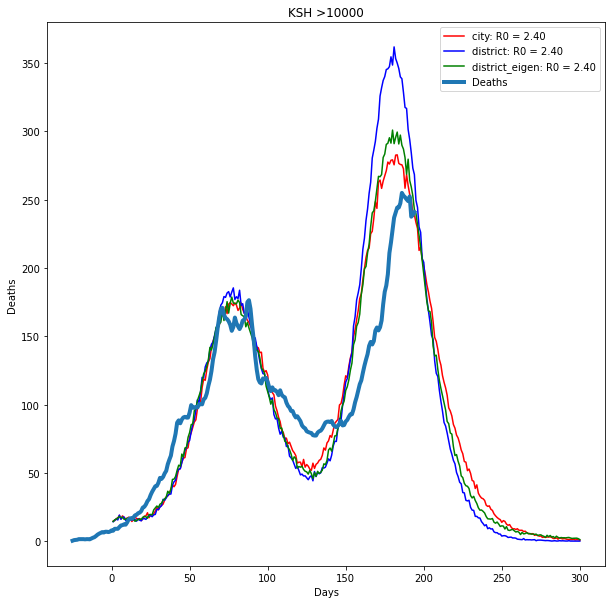

In [25]:
plt.figure(figsize=(10,10))
th = 10000
city = f"KSH2_{th}/base"
district = f"KSH2_{th}/district"
district_eigen = f"KSH2_{th}/district_eigen"

R0 = np.linspace(2.0, 2.6, 10)
for i in [6]:
    death, Is, Is2 = get_inf_curve(f"../../output/{city}/{i}.txt", death = death_ratio*10)
    death_d, Is_d, Is2_d = get_inf_curve(f"../../output/{district}/{i}.txt", death = death_ratio*10)
    death_d2, Is_d2, Is2_d2 = get_inf_curve(f"../../output/{district_eigen}/{i}.txt", death = death_ratio*10)
    
    x = np.array(list(range(1, len(death)+1)))
    plt.plot(x, death, label=f"city: R0 = {R0[i]:.2f}", c='r')
    plt.plot(x, death_d, label=f"district: R0 = {R0[i]:.2f}", c='b')
    x = np.array(list(range(1, len(death_d2)+1)))
    plt.plot(x, death_d2, label=f"district_eigen: R0 = {R0[i]:.2f}", c='g')

x = np.array(range(-25, 220-25))
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = plt.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)
plt.legend()
plt.xlabel('Days')
plt.ylabel("Deaths")
plt.title("KSH >10000")

print(f"City has {100-100*sum(death)/sum(death_d):.2f}% less total infections")
print(f"City has {100-100*sum(death)/sum(death_d2):.2f}% less total infections")

Text(0.5, 1.0, 'KSH 1000 vs 5000 vs 10000 [city]')

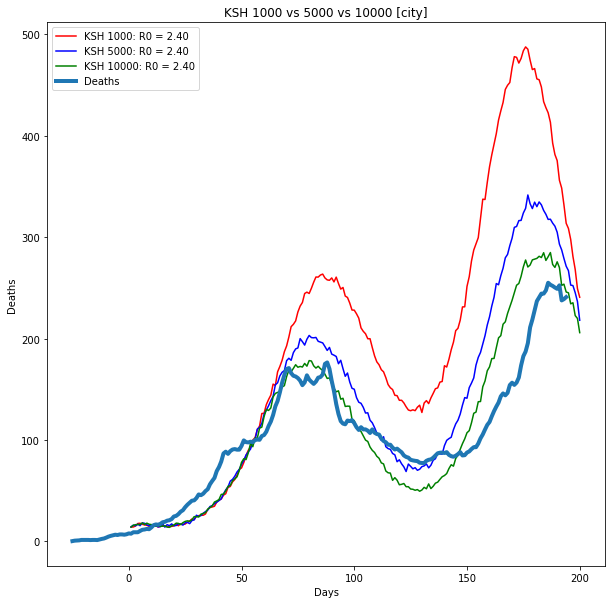

In [11]:
plt.figure(figsize=(10,10))
th = 10000
m1000 = f"KSH_{1000}/base"
m5000 = f"KSH_{5000}/base"
m10000 = f"KSH_{10000}/base"

R0 = np.linspace(2.0, 2.6, 10)
for i in [6]:
    death, Is, Is2 = get_inf_curve(f"../../output/{m1000}/{i}.txt", death = death_ratio*10)
    death_1, Is_1, Is_1 = get_inf_curve(f"../../output/{m5000}/{i}.txt", death = death_ratio*10)
    death_2, Is_2, Is2_2 = get_inf_curve(f"../../output/{m10000}/{i}.txt", death = death_ratio*10)
    
    x = np.array(list(range(1, len(death)+1)))
    plt.plot(x, death, label=f"KSH 1000: R0 = {R0[i]:.2f}", c='r')
    plt.plot(x, death_1, label=f"KSH 5000: R0 = {R0[i]:.2f}", c='b')
    plt.plot(x, death_2, label=f"KSH 10000: R0 = {R0[i]:.2f}", c='g')

x = np.array(range(-25, 220-25))
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = plt.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)
plt.legend()
plt.xlabel('Days')
plt.ylabel("Deaths")
plt.title("KSH 1000 vs 5000 vs 10000 [city]")

In [26]:
i,measure = 6,f"KSH_{5000}/base"
filename = f"../../output/{measure}/{i}.txt"
df = pd.read_csv(filename, sep=',')

def get_time_and_age_agg(city, second=False):
    I = 'I2' if second else 'I_'
    inf_cols = [c for c in df.columns if (c[0:2]==I) and int(c.split('_')[1])==city]
    return df[inf_cols].sum(1), df[inf_cols].sum(0), inf_cols

def get_age_group(city, age_group, second=False):
    I = f'I_{city}_{age_group}'
    I2 = f'I2_{city}_{age_group}'
    return df[[I,I2]].sum(1)

In [27]:
pops = json.load(open("../../input/hun/populations_KSH.json"))['populations']
pops = {int(p['name']): p for p in pops}


big_cities_ind = [k for k,v in pops.items() if v['city'] in ['Budakeszi', 'Debrecen', "Szeged", "Kecskemét", "Győr"] ]

bp_kers = [f"Budapest 0{i}. ker." for i in range(10)]+[f"Budapest {i}. ker." for i in range(11, 24)]
bp_ind = [k for k,v in pops.items() if v['city'] in bp_kers ]

medium_cities = [k for k,v in pops.items() if (v['N'] < 20000)]

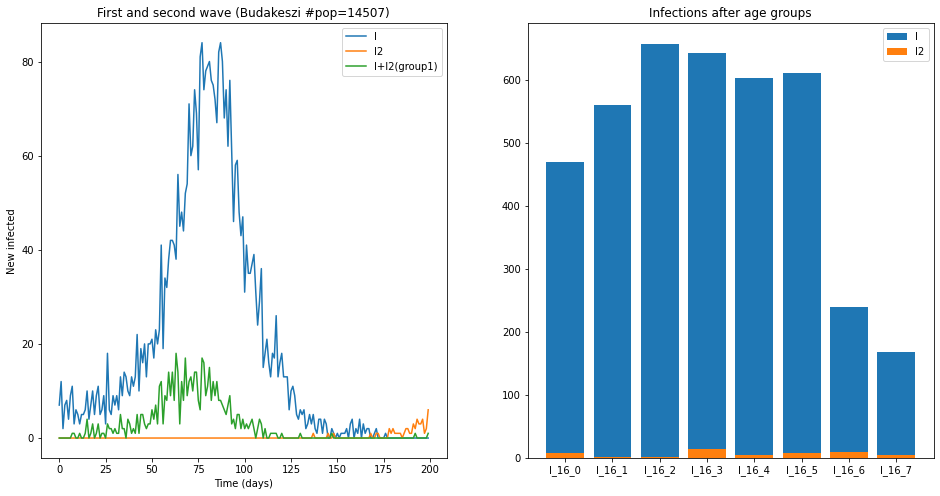

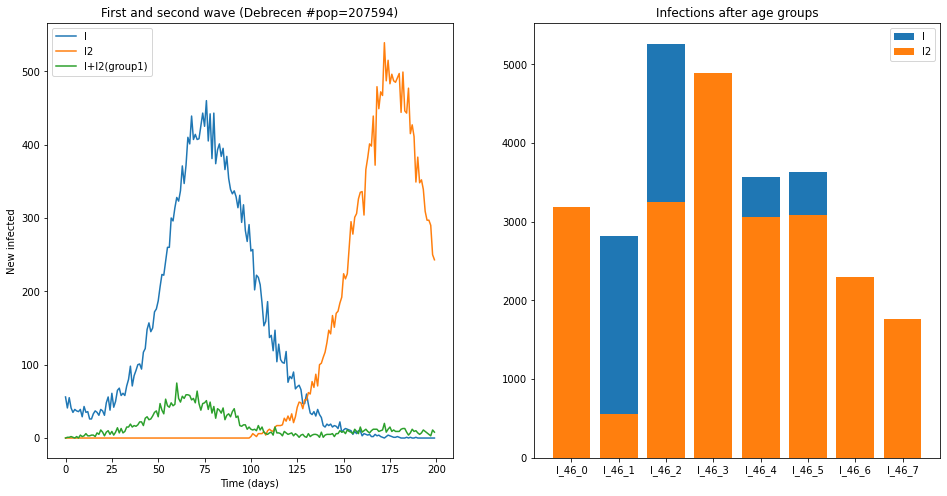

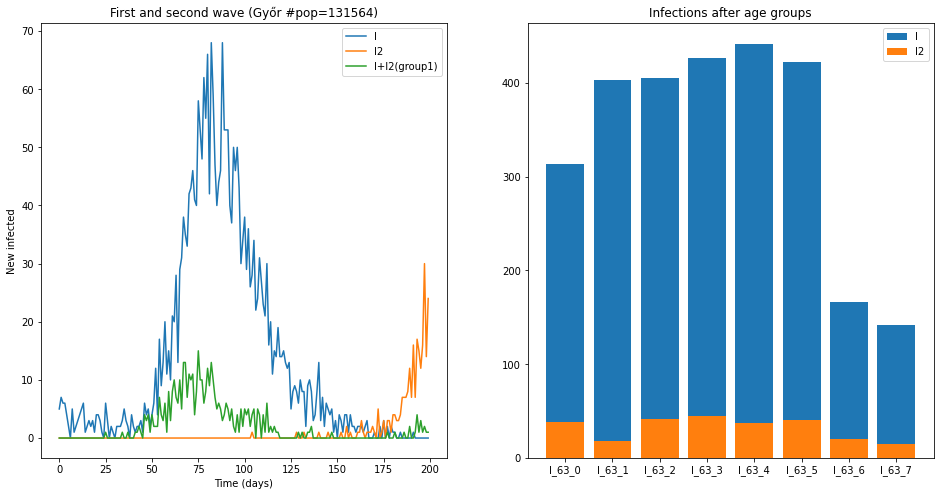

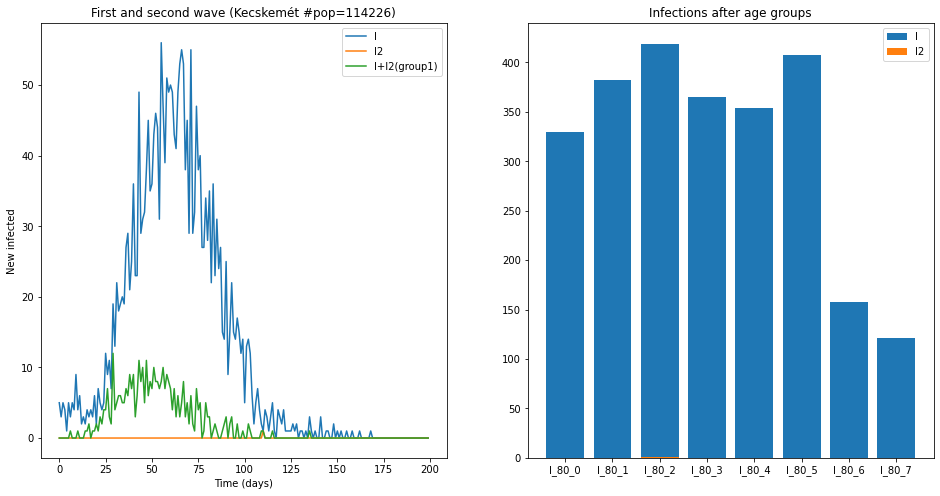

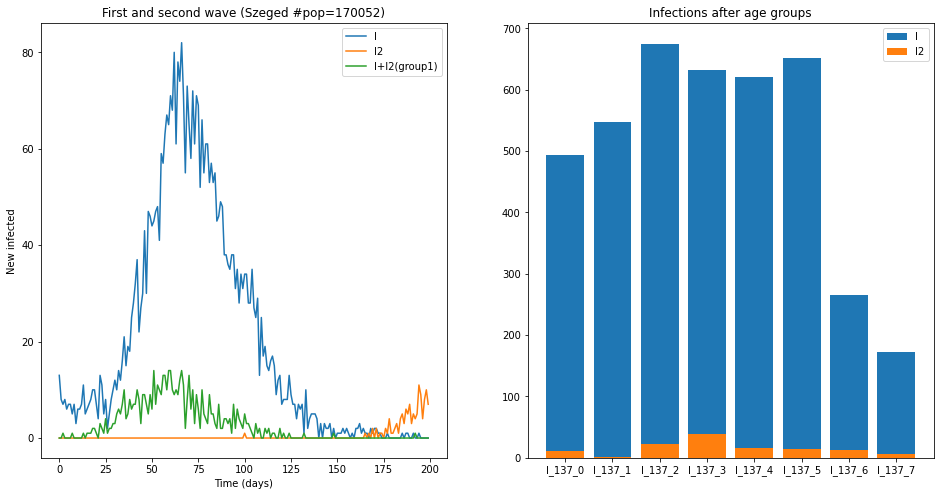

In [30]:
for city in big_cities_ind:
    time, age, name = get_time_and_age_agg(city, second=False)
    group1 = get_age_group(city, 1)
    time2, age2, name2 = get_time_and_age_agg(city, second=True)
    

    fig, axs = plt.subplots(1,2, figsize=(16,8))
    axs[0].plot(time, label="I")
    axs[0].plot(time2, label="I2")
    axs[0].plot(group1, label="I+I2(group1)")
    axs[0].set_title(f"First and second wave ({pops[city]['city']} #pop={pops[city]['N']})")
    axs[0].set_xlabel("Time (days)")
    axs[0].set_ylabel("New infected")
    axs[0].legend()

    axs[1].bar(name, age, label="I")
    axs[1].bar(name, age2, label="I2")
    axs[1].set_title("Infections after age groups")
    axs[1].legend()

    plt.show()

Text(0, 0.5, 'Deaths')

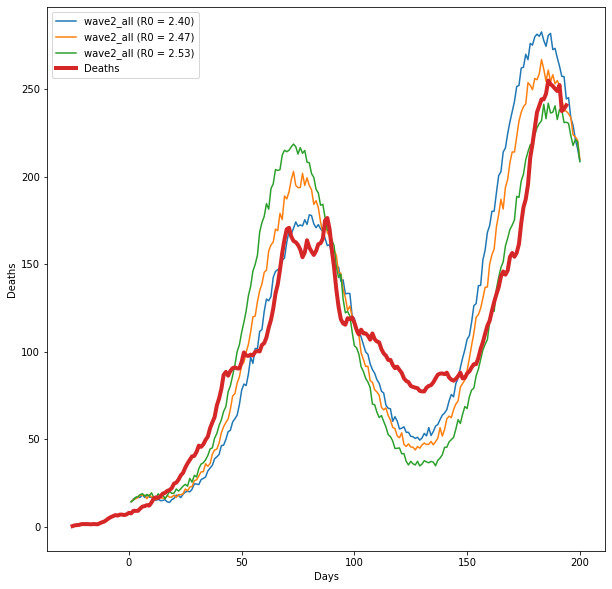

In [13]:
plt.figure(figsize=(10,10))
measure = "district/second_T1:100_F:2.5_s:0.25"
R0 = np.linspace(2.0, 2.6, 10)
for i in [6,7,8]:
    death, Is, Is2 = get_inf_curve(f"../../output/{measure}/{i}.txt", death = death_ratio*10)
    x = np.array(list(range(1, len(death)+1)))
    plt.plot(x, death, label=f"wave2_all (R0 = {R0[i]:.2f})")

x = np.array(range(-25, 220-25))
death_orig = np.array(all_death[181:181+220]["Hétnapos mozgóátlag"])
lns1 = plt.plot(x, death_orig[:len(x)], label="Deaths", linewidth=4)
plt.legend()
plt.xlabel('Days')
plt.ylabel("Deaths")